<a href="https://colab.research.google.com/github/puneethegde72/Weighing-supermassive-black-holes-using-Gaussian-Processes/blob/main/Weighing_Supermasive_backhole_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing all The required Libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import *
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ExpSineSquared
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# Defining Colours
col1 = "#3F5D7D"  # nice deep blue
col2 = '#ff7f0e'  # orange color
col3 = '#1f77b4'  # another shade of blue
colbkg = 'grey'  # background color
bkgalpha = 0.3  # background transparency
plt.rcParams["figure.figsize"] = 10.5, 7  # setting default figure size for plots


In [3]:
# Function to prepare and plot graph
def prepare_plot():
    left, width = 0.5, 0.5  # left position and width of the plot
    bottom, height = 2.83, 0.35  # bottom position and height of the plot
    rect_box1 = [left, bottom, width, height]  # coordinates of the plot rectangle
    fig = plt.figure(facecolor="w")  # create a figure with a white background
    box1 = plt.axes(rect_box1)  # create an axes object within the figure with the specified rectangle
    box1.set_ylim(0., 8.2)  # set the y-axis limits of the plot
    box1.set_xlim(-5., 125.)  # set the x-axis limits of the plot
    box1.xaxis.set_major_locator(FixedLocator([50, 100]))  # set major tick locations on the x-axis
    box1.tick_params(which='major', axis='y', labelsize=14)  # set tick parameters for the y-axis
    box1.tick_params(which='major', axis='x', labelsize=0)  # hide tick labels on the x-axis
    box1.set_ylabel(r'Counts s$^{-1}$', fontsize=14)  # set the label for the y-axis
    return fig, box1  # return the figure and the axes objects


In [4]:
def log_likelihood_value(y, y_pred, sigma_sq):
    n = len(y)  # Number of data points
    log_likelihood = -0.5 * (n * np.log(2 * np.pi) + np.sum(np.log(sigma_sq)) + np.sum(((y - y_pred) ** 2) / sigma_sq))
    return log_likelihood

In [101]:
# Function for Gaussian Process Regression and Plotting_original
def process_and_plot(data_file, box, k, juldate_zero=None, col1=col1, col2=col2, length_scale=0.14):
    data = np.genfromtxt(data_file)  # load data from a file into a numpy array
    juldate = data[:, 1]  # extract the second column (index 1) from the data
    juldate_zero = juldate_zero if juldate_zero is not None else juldate.min()  # set the reference julian date if not provided
    tsec = juldate - juldate_zero  # calculate the time in seconds relative to the reference julian date
    t = tsec / 1000.0  # convert time to seconds
    y = data[:, 2]  # extract the third column (index 2) from the data

    y_error= data[:, 3].T  # add background to the observed data

    X = t.reshape(-1, 1)  # reshape the time array for input to the Gaussian Process Regressor
    y = y.reshape(-1, 1)  # reshape the observed data array
    num_training_data = X.shape[0]  # or y.shape[0]
    print("Number of training data points:", num_training_data)

    kernel = k
    n_opt= 30
    #RBF(length_scale=length_scale) + WhiteKernel(noise_level=0.01)  # create a kernel for the Gaussian Process Regressor
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=y_error, normalize_y=False, n_restarts_optimizer= n_opt)  # create a Gaussian Process Regressor with the specified kernel
    gpr.fit(X, y)  # fit the Gaussian Process Regressor to the data

    #finding the final value here.
    print("final values of the kernals are:",gpr.kernel_)

    # Get the log-likelihood of the fitted model
    log_likelihood = gpr.log_marginal_likelihood()

    print('log_likelihood', log_likelihood)

    y_pred, sigma = gpr.predict(X, return_std=True)  # predict the values and uncertainty using the trained model


    # Compute and print the BIC
    n = num_training_data  # Number of data points
    print("training datapoint",n)
    k = len(gpr.kernel_.theta)  # Number of parameters used in the model
    print("K",k)



    a=(-2)* log_likelihood
    print('a=', a)
    aa=((np.log(n))*k)
    print('aa=', aa)
    #BIC = ((-2)* log_likelihood) + (np.log(n)*k)
    BIC=a+aa
    print("Bayesian Information Criterion (BIC):", BIC)


    # Calculate AICc
    AIC = 2 * k - 2 * log_likelihood
    print('AIC=',AIC)
    edf=(n - k - 1) #effective degrees of freedom
    b= (2 * k * (k + 1))
    AICc = (AIC + b)/ edf
    print('(2 * k * (k + 1))=', b)
    print('(n - k - 1)=', edf)
    print("Corrected Akaike Information Criterion (AICc):", AICc)


    # Calculate mean squared error
    mse = mean_squared_error(y, y_pred)
    print("Mean Squared Error (MSE):", mse)

    # Calculate R-squared value
    r2 = r2_score(y, y_pred)
    print("R-squared value:", r2)

    box.plot(t, y, color=col1, linewidth=1.5, label='Observations')  # plot the observed data
    plt.errorbar(
        X,
        y.flatten(),
        yerr=y_error.flatten(),
        linestyle="None",
        color="tab:red",
        marker=".",
        markersize=5,
        label="Error",
    )  # plot error bars representing noise in the data
    box.plot(t, y_pred, color=col2, linewidth=1.5, label='Gaussian Process')  # plot the Gaussian Process
    print(y_pred)
    box.fill_between(t, y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color=col2, alpha=0.2, label=r"95% confidence interval")  # fill the area between predictions with uncertainty
    plt.title(str(gpr.kernel_))
    return juldate_zero, AICc, BIC, log_likelihood,gpr.kernel_, k  # return the reference julian date and BIC and AICc


In [51]:
# Function for Gaussian Process Regression and Plotting_2
def process_and_plot(data_file, box, k, juldate_zero=None, col1=col1, col2=col2, length_scale=0.14):
    data = np.genfromtxt(data_file)  # load data from a file into a numpy array
    juldate = data[:, 1]  # extract the second column (index 1) from the data
    juldate_zero = juldate_zero if juldate_zero is not None else juldate.min()  # set the reference julian date if not provided
    tsec = juldate - juldate_zero  # calculate the time in seconds relative to the reference julian date
    t = tsec / 1000.0  # convert time to seconds
    y = data[:, 2]  # extract the third column (index 2) from the data

    y_error= data[:, 3].T  # add background to the observed data

    X = t.reshape(-1, 1)  # reshape the time array for input to the Gaussian Process Regressor
    y = y.reshape(-1, 1)  # reshape the observed data array
    num_training_data = X.shape[0]  # or y.shape[0]
    print("Number of training data points:", num_training_data)

    kernel = k
    n_opt = 50
    #RBF(length_scale=length_scale) + WhiteKernel(noise_level=0.01)  # create a kernel for the Gaussian Process Regressor
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=y_error, normalize_y=False, n_restarts_optimizer= n_opt)  # create a Gaussian Process Regressor with the specified kernel
    gpr.fit(X, y)  # fit the Gaussian Process Regressor to the data

    #finding the final value here.
    print("final values of the kernals are:",gpr.kernel_)


    y_pred, sigma = gpr.predict(X, return_std=True)  # predict the values and uncertainty using the trained model

    # Get the log-likelihood of the fitted model
    # Calculate negative log-likelihood
    '''neg_log_likelihood = -gpr.log_marginal_likelihood()
    print('negetive likelihood', neg_log_likelihood)

    #converting to +likelyhood
    log_likelihood = -0.5 * (num_training_data * np.log(2 * np.pi) + neg_log_likelihood)
    '''
    log_likelihood = log_likelihood_value(y.flatten(), y_pred.flatten(), sigma**2)
    print('log_likelihood', log_likelihood)

    y_pred, sigma = gpr.predict(X, return_std=True)  # predict the values and uncertainty using the trained model


    # Compute and print the BIC
    n = num_training_data  # Number of data points
    print("training datapoint",n)
    k = len(gpr.kernel_.theta)  # Number of parameters used in the model
    print("K",k)

    BIC = (-2* log_likelihood) + (np.log(n)*k)
    print("Bayesian Information Criterion (BIC):", BIC)


    # Calculate AICc
    AIC = (-2 * log_likelihood) + (2 * k)

    AICc = AIC + ((2 * k) * (k + 1)) / (n - k - 1)
    print("Corrected Akaike Information Criterion (AICc):", AICc)


    # Calculate mean squared error
    mse = mean_squared_error(y, y_pred)
    print("Mean Squared Error (MSE):", mse)

    # Calculate R-squared value
    r2 = r2_score(y, y_pred)
    print("R-squared value:", r2)

    box.plot(t, y, color=col1, linewidth=1.5, label='Observations')  # plot the observed data
    plt.errorbar(
        X,
        y.flatten(),
        yerr=y_error.flatten(),
        linestyle="None",
        color="tab:red",
        marker=".",
        markersize=5,
        label="Error",
    )  # plot error bars representing noise in the data
    box.plot(t, y_pred, color=col2, linewidth=1.5, label='Gaussian Process')  # plot the Gaussian Process
    print(y_pred)
    box.fill_between(t, y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color=col2, alpha=0.2, label=r"95% confidence interval")  # fill the area between predictions with uncertainty
    plt.title(str(gpr.kernel_))
    return juldate_zero, AICc, BIC, log_likelihood,gpr.kernel_, k  # return the reference julian date and BIC and AICc


In [102]:
# Function to combine data from multiple files
def combine_data_files(data_files):
    data_combined = np.array([])  # initialize an empty numpy array
    for data_file in data_files:
        data = np.genfromtxt(data_file)  # load data from a file into a numpy array
        if data_combined.size == 0:  # if the combined data array is still empty
            data_combined = data  # set the combined data array to the data array
        else:  # if the combined data array is not empty
            data_combined = np.concatenate((data_combined, data))  # concatenate the data array to the combined data array
    return data_combined  # return the combined data array


In [103]:
# Data files
data_files = ['fvar_soft_dt1000_ob1.dat', 'fvar_soft_dt1000_ob2.dat', 'fvar_soft_dt1000_ob3.dat',
              'fvar_soft_dt1000_ob4.dat', 'fvar_soft_dt1000_ob5.dat', 'fvar_soft_dt1000_ob6.dat']


In [104]:
# List of kernels
kernels = [
    1.0**2 * RBF(length_scale=0.14) + RBF(length_scale=0.01) + WhiteKernel(noise_level=0.01),
    1.0**2 * RBF(length_scale=0.14) + Matern(length_scale=0.1) + WhiteKernel(noise_level=0.01),
    1.0**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01),
    1.0**2 * RBF(length_scale=0.24) + RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01),
    1.0**2 * RBF(length_scale=0.4) + RBF(length_scale=0.2) + RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
    1.0**2 * RBF(length_scale=0.1) + ExpSineSquared(length_scale=0.1, periodicity=0.1) +WhiteKernel(noise_level=0.01),
    1.0**2 * RBF(length_scale=0.4) + ExpSineSquared(length_scale=0.0001, periodicity=0.1)+ WhiteKernel(noise_level=0.01)
]
#kernal_Model1 =1.0**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)


In [105]:
Result_Table_box1 = pd.DataFrame(columns=['Kernel', 'k','log likelihood','BIC', 'AICc'])

kernals: 1**2 * RBF(length_scale=0.14) + RBF(length_scale=0.01) + WhiteKernel(noise_level=0.01)
Number of training data points: 123


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 4.55**2 * RBF(length_scale=1e+03) + RBF(length_scale=2.46) + WhiteKernel(noise_level=1e-05)
log_likelihood -85.95488705136256
training datapoint 123
K 4
a= 171.90977410272512
aa= 19.24873742148967
Bayesian Information Criterion (BIC): 191.1585115242148
AIC= 179.90977410272512
(2 * k * (k + 1))= 40
(n - k - 1)= 118
Corrected Akaike Information Criterion (AICc): 1.8636421534129248
Mean Squared Error (MSE): 0.043737201998194156
R-squared value: 0.9483683723378205
[4.9087307  5.63945655 6.10844644 6.09330019 5.70435174 5.29402738
 5.15469473 5.28049943 5.39404272 5.20207871 4.67822269 4.14109399
 4.01069124 4.40371708 4.96190662 5.1451455  4.72957554 3.99508223
 3.4129067  3.19242964 3.17944123 3.16011871 3.1433686  3.27478292
 3.56448245 3.84953184 4.03309898 4.22964807 4.60307447 5.13289499
 5.6164218  5.87670994 5.91370841 5.85482777 5.80131361 5.75540111
 5.69121581 5.64470268 5.68289129 5.80362657 5.92236956 5.95711578
 5.89092006 5.77977951 5.75066059

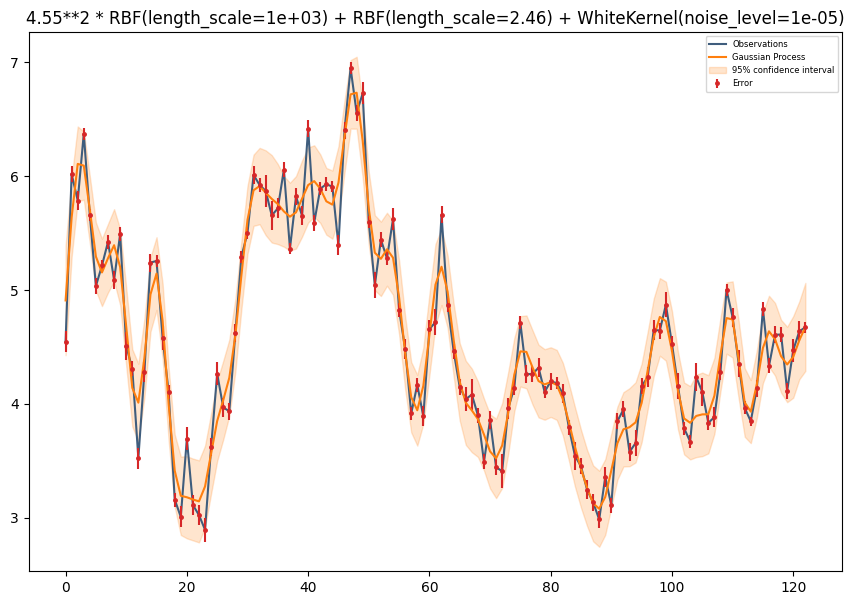

<ipython-input-106-8fe898b9001c>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': k,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


441220800.0
kernals: 1**2 * RBF(length_scale=0.14) + Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.01)
Number of training data points: 123


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 4.56**2 * RBF(length_scale=1e+05) + Matern(length_scale=4.58, nu=1.5) + WhiteKernel(noise_level=1e-05)
log_likelihood -84.13349851945965
training datapoint 123
K 4
a= 168.2669970389193
aa= 19.24873742148967
Bayesian Information Criterion (BIC): 187.51573446040896
AIC= 176.2669970389193
(2 * k * (k + 1))= 40
(n - k - 1)= 118
Corrected Akaike Information Criterion (AICc): 1.8327711613467736
Mean Squared Error (MSE): 0.037461483516546046
R-squared value: 0.9557768380181466
[4.99168078 5.63102549 6.00652913 6.07729507 5.70265803 5.30429741
 5.22526452 5.29440974 5.28526124 5.15632515 4.70453548 4.23478271
 4.03885118 4.40389051 4.95126174 5.07714604 4.66300826 4.01182698
 3.41196613 3.21234889 3.25898221 3.17102915 3.08718619 3.20678687
 3.57984214 3.9119829  4.01922136 4.18431783 4.63458979 5.17334797
 5.57550486 5.85144233 5.91505376 5.85146909 5.78004454 5.78017334
 5.75626031 5.61026098 5.67981508 5.84052677 5.97569789 5.87454297
 5.85204413 5.85775589 

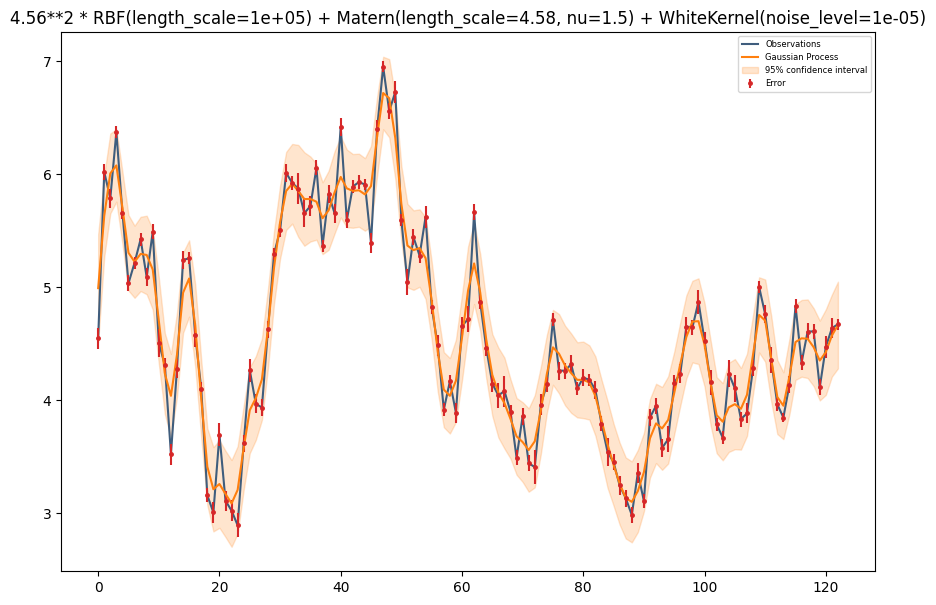

<ipython-input-106-8fe898b9001c>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': k,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


441220800.0
kernals: 1**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)
Number of training data points: 123
final values of the kernals are: 3.61**2 * RBF(length_scale=8.1) + WhiteKernel(noise_level=0.0862)
log_likelihood -111.57609271257374
training datapoint 123
K 3
a= 223.15218542514748
aa= 14.436553066117252
Bayesian Information Criterion (BIC): 237.58873849126473
AIC= 229.15218542514748
(2 * k * (k + 1))= 24
(n - k - 1)= 119
Corrected Akaike Information Criterion (AICc): 2.1273292892869535
Mean Squared Error (MSE): 0.13256940921569163
R-squared value: 0.8435022346353498
[5.27038162 5.55698765 5.71605462 5.7568734  5.69913719 5.56996635
 5.39983644 5.218041   5.04843752 4.90620841 4.79621456 4.71324684
 4.64413987 4.57136515 4.47743734 4.34930513 4.18189261 3.9801115
 3.75895015 3.54160629 3.35599454 3.23025802 3.1880868  3.24466729
 3.40395548 3.65771603 3.98645102 4.36201971 4.75148264 5.12153292
 5.4428258  5.69358065 5.8619841  5.94713236 5.9584743  5.91391994
 5.836

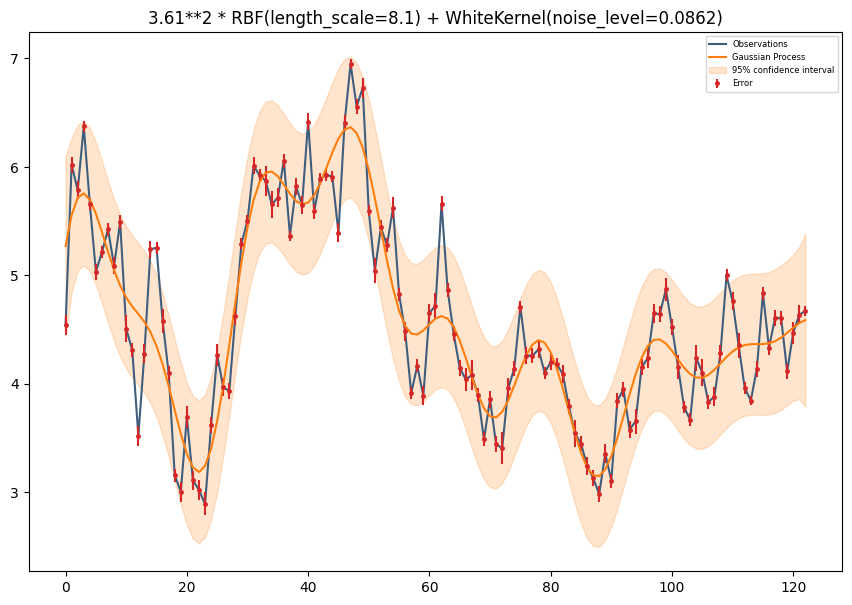

<ipython-input-106-8fe898b9001c>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': k,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


441220800.0
kernals: 1**2 * RBF(length_scale=0.24) + RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)
Number of training data points: 123


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 4.55**2 * RBF(length_scale=1e+03) + RBF(length_scale=2.46) + WhiteKernel(noise_level=1e-05)
log_likelihood -85.95488705130715
training datapoint 123
K 4
a= 171.9097741026143
aa= 19.24873742148967
Bayesian Information Criterion (BIC): 191.15851152410397
AIC= 179.9097741026143
(2 * k * (k + 1))= 40
(n - k - 1)= 118
Corrected Akaike Information Criterion (AICc): 1.8636421534119856
Mean Squared Error (MSE): 0.04373716266753878
R-squared value: 0.9483684187675339
[4.90873036 5.63945653 6.10844667 6.09330037 5.70435168 5.29402717
 5.15469456 5.28049939 5.39404285 5.20207899 4.67822289 4.14109381
 4.01069076 4.40371679 4.96190685 5.14514596 4.72957565 3.99508186
 3.41290635 3.19242983 3.17944177 3.16011892 3.14336823 3.27478252
 3.56448256 3.84953227 4.03309912 4.2296478  4.60307419 5.13289503
 5.61642201 5.87671001 5.91370824 5.85482756 5.80131358 5.75540125
 5.69121588 5.64470258 5.6828912  5.8036266  5.92236958 5.95711572
 5.89092007 5.77977963 5.75066056 5

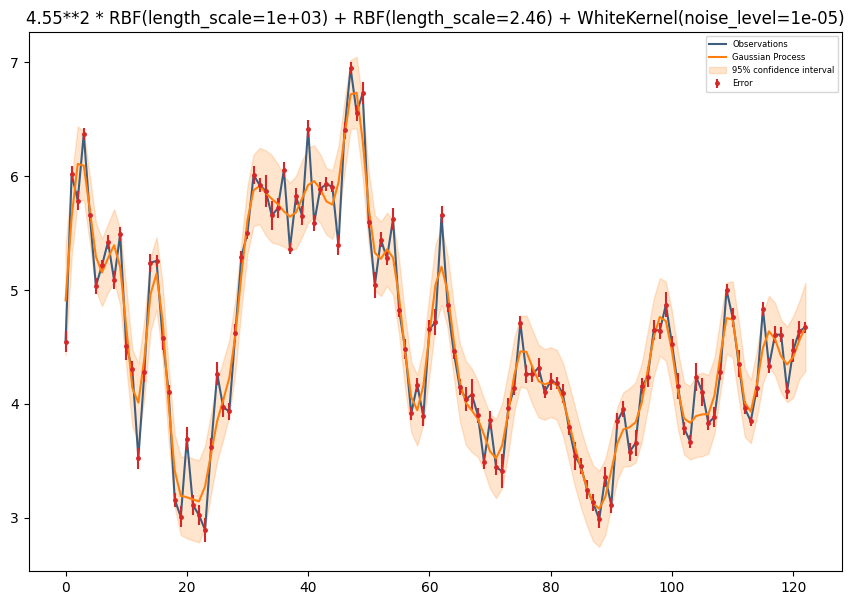

<ipython-input-106-8fe898b9001c>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': k,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


441220800.0
kernals: 1**2 * RBF(length_scale=0.4) + RBF(length_scale=0.2) + RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 123


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 4.44**2 * RBF(length_scale=976) + RBF(length_scale=1e+05) + RBF(length_scale=2.46) + WhiteKernel(noise_level=1e-05)
log_likelihood -85.95488016816978
training datapoint 123
K 5
a= 171.90976033633956
aa= 24.060921776862084
Bayesian Information Criterion (BIC): 195.97068211320163
AIC= 181.90976033633956
(2 * k * (k + 1))= 60
(n - k - 1)= 117
Corrected Akaike Information Criterion (AICc): 2.0676047891994833
Mean Squared Error (MSE): 0.04373433371148578
R-squared value: 0.9483717583411446
[4.90870929 5.63945478 6.10846296 6.09331374 5.7043481  5.29401268
 5.15468245 5.28049689 5.39405311 5.20209991 4.67823759 4.14108124
 4.01065651 4.40369643 4.96192416 5.14517996 4.72958435 3.99505535
 3.41288149 3.19244392 3.17948121 3.16013433 3.14334191 3.27475367
 3.56449102 3.84956338 4.03310973 4.22962821 4.60305437 5.13289795
 5.61643773 5.87671573 5.91369678 5.8548126  5.8013119  5.75541149
 5.69122101 5.64469573 5.68288507 5.80362941 5.92237169 5.95711191
 5.89092

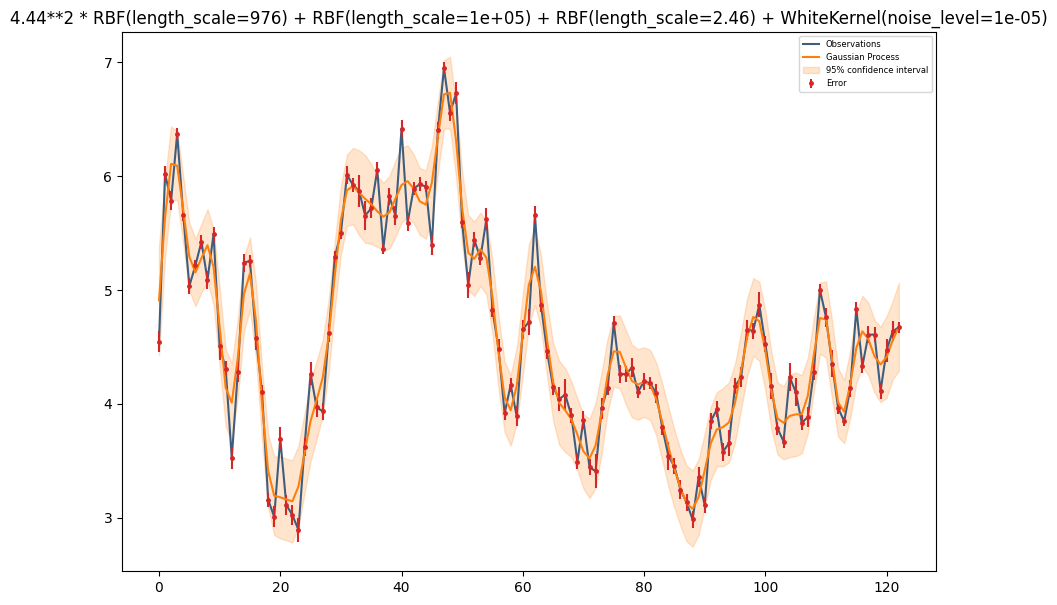

<ipython-input-106-8fe898b9001c>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': k,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


441220800.0
kernals: 1**2 * RBF(length_scale=0.1) + ExpSineSquared(length_scale=0.1, periodicity=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 123


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 0.85**2 * RBF(length_scale=2.36) + ExpSineSquared(length_scale=15.7, periodicity=1.96) + WhiteKernel(noise_level=1e-05)
log_likelihood -91.24669951702805
training datapoint 123
K 5
a= 182.4933990340561
aa= 24.060921776862084
Bayesian Information Criterion (BIC): 206.55432081091817
AIC= 192.4933990340561
(2 * k * (k + 1))= 60
(n - k - 1)= 117
Corrected Akaike Information Criterion (AICc): 2.158063239607317
Mean Squared Error (MSE): 0.038960962635860893
R-squared value: 0.9540067076934204
[4.8576867  5.70223747 5.98946244 6.14508879 5.62194719 5.38724691
 5.08995863 5.34921131 5.29281089 5.24023951 4.58694375 4.20107103
 3.94962343 4.46054549 4.88962386 5.17144332 4.65889687 4.03133313
 3.38062325 3.2410722  3.16068798 3.19013399 3.12388331 3.29259742
 3.56051243 3.85865503 4.03274447 4.22213135 4.61409562 5.11507709
 5.62720325 5.83255965 5.92300062 5.79855891 5.82533976 5.70179025
 5.73658516 5.59017338 5.7373212  5.73822844 5.97452008 5.8740509
 5.9445

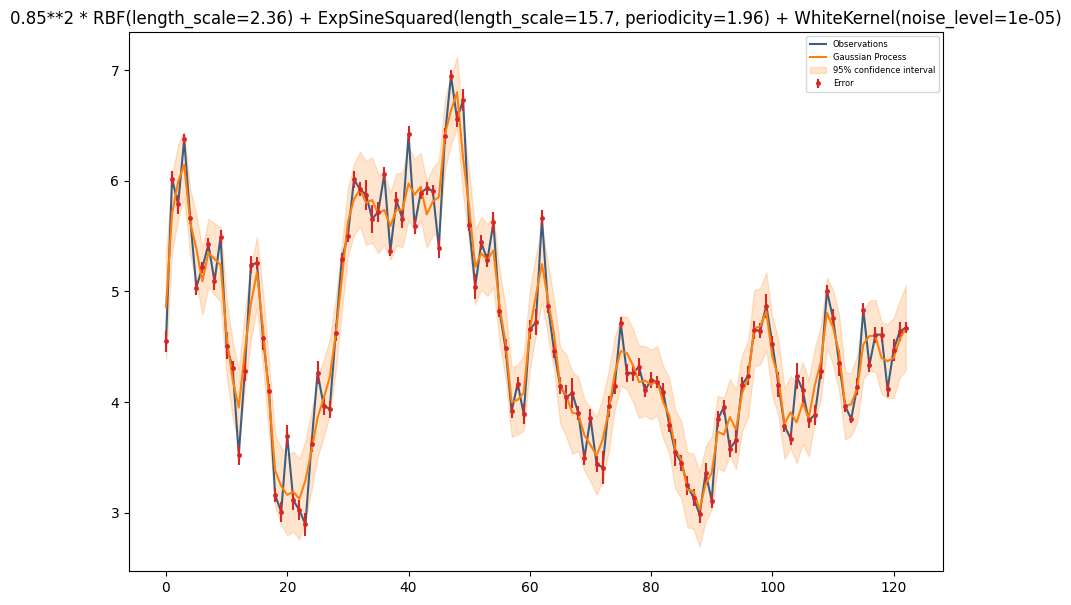

<ipython-input-106-8fe898b9001c>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': k,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


441220800.0
kernals: 1**2 * RBF(length_scale=0.4) + ExpSineSquared(length_scale=0.0001, periodicity=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 123


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 0.852**2 * RBF(length_scale=2.35) + ExpSineSquared(length_scale=5.22e+03, periodicity=1.84e+03) + WhiteKernel(noise_level=1e-05)
log_likelihood -93.25869996569823
training datapoint 123
K 5
a= 186.51739993139645
aa= 24.060921776862084
Bayesian Information Criterion (BIC): 210.57832170825853
AIC= 196.51739993139645
(2 * k * (k + 1))= 60
(n - k - 1)= 117
Corrected Akaike Information Criterion (AICc): 2.1924564096700547
Mean Squared Error (MSE): 0.0438052157294851
R-squared value: 0.9482880823446455
[4.90817568 5.62543147 6.08863787 6.07709267 5.69669161 5.29412415
 5.15533239 5.27256482 5.37734135 5.18791718 4.67639672 4.14846937
 4.01636203 4.40081305 4.95144042 5.13263316 4.72063733 3.99262573
 3.41736152 3.20267814 3.19111956 3.16660433 3.14327231 3.27468958
 3.56920942 3.85459604 4.03259778 4.22570053 4.60046125 5.13005165
 5.60878666 5.863966   5.89853106 5.83959422 5.78874169 5.74683877
 5.68395969 5.6363587  5.67535955 5.79709413 5.9118556  5.94196

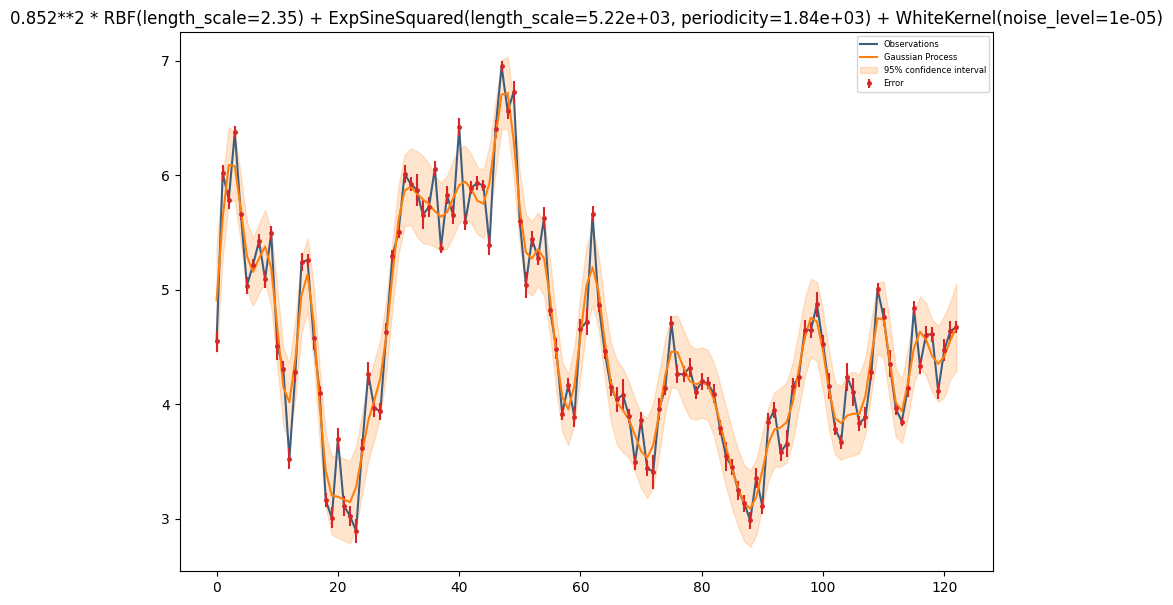

441220800.0


<ipython-input-106-8fe898b9001c>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': k,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


In [106]:
# Plotting
for i, kernel in enumerate(kernels):
  print('kernals:',kernel)
  fig, box1 = plt.subplots()   # create the figure and the first axes object
  juldate_zero, AICc, BIC, log_likelihood, final_kernal_value,k = process_and_plot(data_files[0], box1,kernel)  # process and plot the first data file on the first axes object
  plt.legend(loc='upper right', fontsize="6")  # add a legend to the plot
  name= "Boxplot1_"+str(final_kernal_value)+".png"
  plt.savefig(name)
  plt.show()  # display the plot
  Result_Table_box1 = Result_Table_box1.append({'Kernel': str(final_kernal_value), 'k': k,'log likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)
  print(juldate_zero)


In [107]:
Result_Table_box1.to_csv("gp_Result_Table_box1.csv")
Result_Table_box1

Kernel  k  log likelihood  \
0  4.55**2 * RBF(length_scale=1e+03) + RBF(length...  4      -85.954887   
1  4.56**2 * RBF(length_scale=1e+05) + Matern(len...  4      -84.133499   
2  3.61**2 * RBF(length_scale=8.1) + WhiteKernel(...  3     -111.576093   
3  4.55**2 * RBF(length_scale=1e+03) + RBF(length...  4      -85.954887   
4  4.44**2 * RBF(length_scale=976) + RBF(length_s...  5      -85.954880   
5  0.85**2 * RBF(length_scale=2.36) + ExpSineSqua...  5      -91.246700   
6  0.852**2 * RBF(length_scale=2.35) + ExpSineSqu...  5      -93.258700   

          BIC      AICc  
0  191.158512  1.863642  
1  187.515734  1.832771  
2  237.588738  2.127329  
3  191.158512  1.863642  
4  195.970682  2.067605  
5  206.554321  2.158063  
6  210.578322  2.192456

In [108]:
  # Combine the data files
data_combined = combine_data_files(data_files[1:-1])
data_combined
np.savetxt('fvar_soft_dt1000_combined.dat', data_combined)

In [109]:
Result_Table_box2 = pd.DataFrame(columns=['Kernel', 'k','log_likelihood','BIC', 'AICc'])

kernals: 1**2 * RBF(length_scale=0.14) + RBF(length_scale=0.01) + WhiteKernel(noise_level=0.01)
Number of training data points: 481


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 0.577**2 * RBF(length_scale=3.77) + RBF(length_scale=493) + WhiteKernel(noise_level=1e-05)
log_likelihood -178.9239671605655
training datapoint 481
K 4
a= 357.847934321131
aa= 24.703469080423044
Bayesian Information Criterion (BIC): 382.551403401554
AIC= 365.847934321131
(2 * k * (k + 1))= 40
(n - k - 1)= 476
Corrected Akaike Information Criterion (AICc): 0.8526217107586785
Mean Squared Error (MSE): 0.04051371172519616
R-squared value: 0.9203546908667971
[2.74736495 2.70608203 2.66995286 2.64780901 2.64207771 2.64901175
 2.66267677 2.6802374  2.70488691 2.74396105 2.80280899 2.87796024
 2.95405417 3.00720546 3.01399917 2.96214032 2.85763463 2.72478321
 2.59849468 2.51192465 2.4846466  2.51641742 2.58911329 2.67563614
 2.75128968 2.80201294 2.82570804 2.82689015 2.80877863 2.76828246
 2.69715133 2.58830377 2.44295096 2.27387402 2.1029708  1.95475451
 1.84944334 1.7987653  1.80551804 1.86582555 1.97198578 2.11405255
 2.2795336  2.45217778 2.61187703 2.737

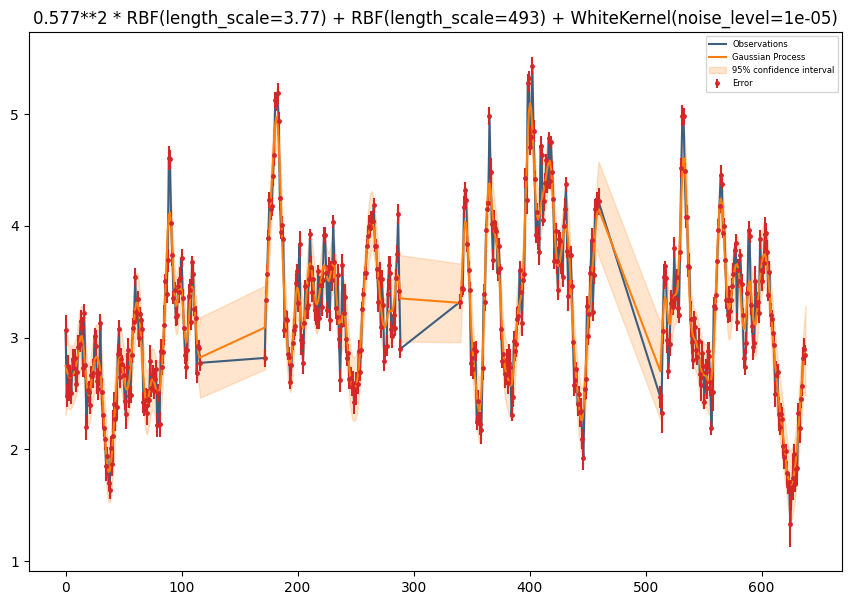

<ipython-input-110-0ae14b276f41>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k':k,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


535464900.0
kernals: 1**2 * RBF(length_scale=0.14) + Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.01)
Number of training data points: 481


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 3.18**2 * RBF(length_scale=1e+05) + Matern(length_scale=9.82, nu=1.5) + WhiteKernel(noise_level=1e-05)
log_likelihood -179.10382011735317
training datapoint 481
K 4
a= 358.20764023470633
aa= 24.703469080423044
Bayesian Information Criterion (BIC): 382.91110931512935
AIC= 366.20764023470633
(2 * k * (k + 1))= 40
(n - k - 1)= 476
Corrected Akaike Information Criterion (AICc): 0.8533773954510637
Mean Squared Error (MSE): 0.03657581244403309
R-squared value: 0.9280961490602856
[2.79714902 2.72568657 2.67324594 2.64187507 2.63494633 2.64871323
 2.67800964 2.70320253 2.72177006 2.74632184 2.80089042 2.87840343
 2.95270003 2.99941945 2.99714307 2.9479895  2.86306127 2.73325576
 2.60428845 2.52787773 2.50611978 2.53215584 2.5980343  2.67865579
 2.75594629 2.80856313 2.81472706 2.79177294 2.77186293 2.75879796
 2.71088686 2.58641479 2.41758446 2.24320864 2.084161   1.95117625
 1.85379377 1.79789895 1.80207464 1.86849598 1.97491613 2.112088
 2.26351383 2.41629489

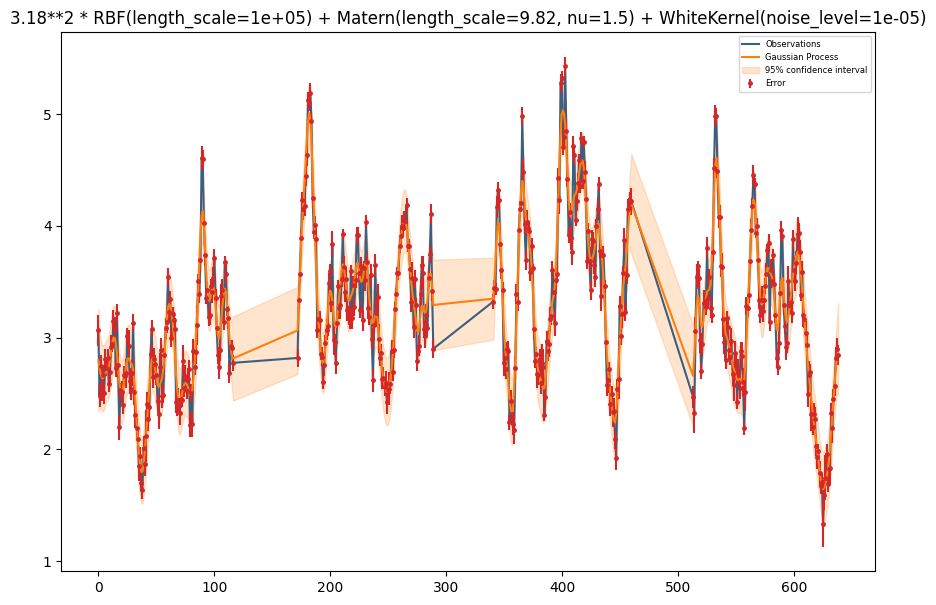

<ipython-input-110-0ae14b276f41>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k':k,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


535464900.0
kernals: 1**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)
Number of training data points: 481


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 2.49**2 * RBF(length_scale=8.34) + WhiteKernel(noise_level=1e-05)
log_likelihood -248.51842629045464
training datapoint 481
K 3
a= 497.0368525809093
aa= 18.527601810317282
Bayesian Information Criterion (BIC): 515.5644543912266
AIC= 503.0368525809093
(2 * k * (k + 1))= 24
(n - k - 1)= 477
Corrected Akaike Information Criterion (AICc): 1.1048990620144847
Mean Squared Error (MSE): 0.0596680585600812
R-squared value: 0.8826994425583524
[2.7639237  2.71646182 2.66951337 2.63231827 2.61232736 2.61420552
 2.63915433 2.6846817  2.74488913 2.81127253 2.87395047 2.92315773
 2.9507868  2.95173642 2.92484157 2.87321424 2.80391077 2.72694791
 2.65379704 2.59557721 2.56122528 2.5559356  2.58012844 2.62913018
 2.69364147 2.76094848 2.81671636 2.84711137 2.8409426  2.79150443
 2.6978382  2.56521035 2.40471328 2.23201966 2.06544266 1.92355755
 1.82270945 1.77475735 1.78538121 1.85320864 1.96990815 2.12126134
 2.28908454 2.45374179 2.59689512 2.70409114 2.76679451 2.783

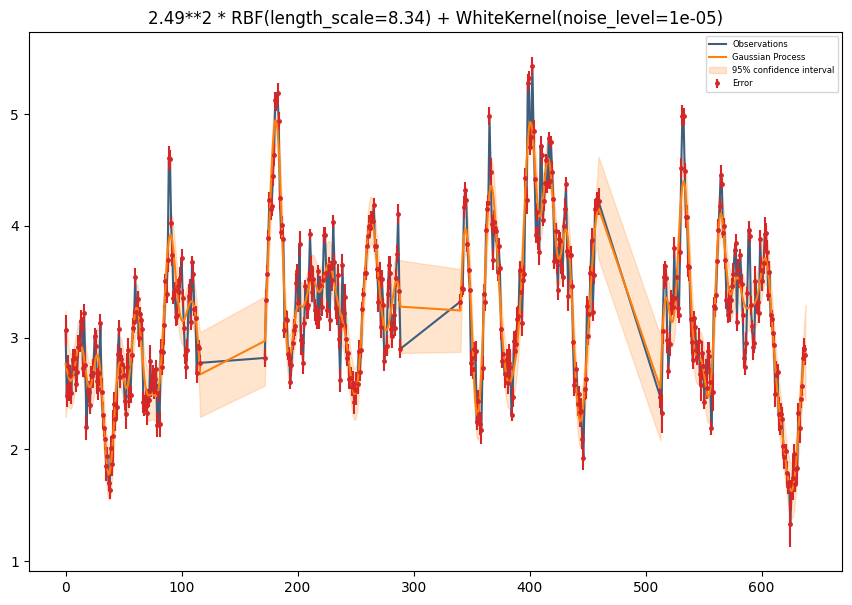

<ipython-input-110-0ae14b276f41>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k':k,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


535464900.0
kernals: 1**2 * RBF(length_scale=0.24) + RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)
Number of training data points: 481


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 0.577**2 * RBF(length_scale=3.77) + RBF(length_scale=493) + WhiteKernel(noise_level=1e-05)
log_likelihood -178.92396716059858
training datapoint 481
K 4
a= 357.84793432119716
aa= 24.703469080423044
Bayesian Information Criterion (BIC): 382.5514034016202
AIC= 365.84793432119716
(2 * k * (k + 1))= 40
(n - k - 1)= 476
Corrected Akaike Information Criterion (AICc): 0.8526217107588175
Mean Squared Error (MSE): 0.0405137020428887
R-squared value: 0.9203547099011027
[2.74736501 2.70608204 2.66995284 2.64780898 2.6420777  2.64901175
 2.66267679 2.68023742 2.70488691 2.74396103 2.80280896 2.87796022
 2.95405417 3.0072055  3.01399923 2.96214038 2.85763466 2.7247832
 2.59849463 2.51192459 2.48464655 2.51641739 2.58911329 2.67563617
 2.75128971 2.80201295 2.82570803 2.82689014 2.80877862 2.76828246
 2.69715136 2.5883038  2.44295097 2.27387401 2.10297077 1.95475446
 1.84944329 1.79876525 1.805518   1.86582551 1.97198574 2.11405251
 2.27953357 2.45217776 2.61187704 2

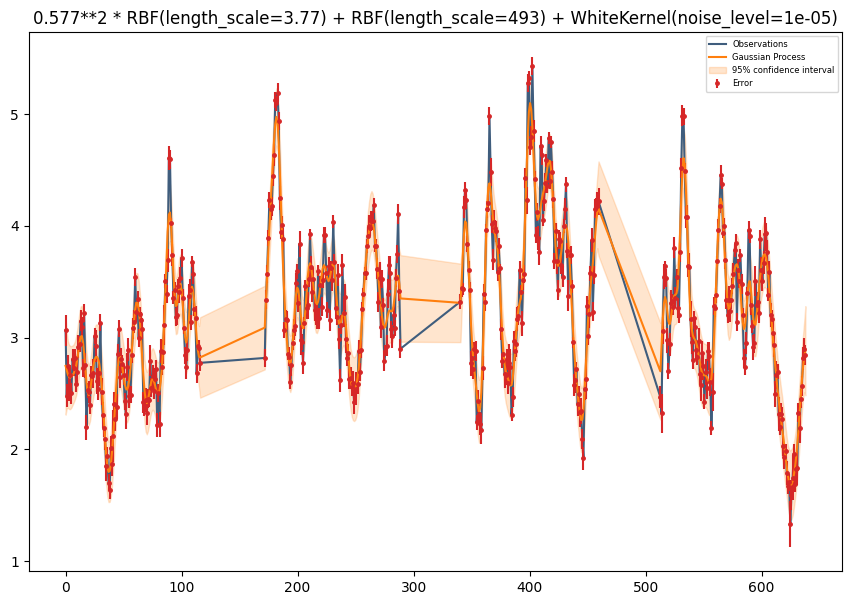

<ipython-input-110-0ae14b276f41>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k':k,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


535464900.0
kernals: 1**2 * RBF(length_scale=0.4) + RBF(length_scale=0.2) + RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 481


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 0.577**2 * RBF(length_scale=3.76) + RBF(length_scale=514) + RBF(length_scale=514) + WhiteKernel(noise_level=1e-05)
log_likelihood -176.70389455498258
training datapoint 481
K 5
a= 353.40778910996517
aa= 30.879336350528806
Bayesian Information Criterion (BIC): 384.287125460494
AIC= 363.40778910996517
(2 * k * (k + 1))= 60
(n - k - 1)= 475
Corrected Akaike Information Criterion (AICc): 0.891384819178874
Mean Squared Error (MSE): 0.040512622014385886
R-squared value: 0.9203568331132281
[2.74605619 2.70542814 2.66966978 2.64768448 2.64199065 2.64891296
 2.66255199 2.68007849 2.70468468 2.7437147  2.80253614 2.87769473
 2.95383071 3.00704107 3.01388318 2.96203918 2.85750891 2.72460824
 2.59827436 2.51169117 2.48444499 2.51628138 2.58904432 2.67559852
 2.75122699 2.80187949 2.82549725 2.82664074 2.80855252 2.76812776
 2.69707536 2.58827382 2.44292036 2.27381322 2.10288254 1.95466625
 1.84938596 1.79875313 1.80554079 1.86585403 1.9719875  2.11400943
 2.2794527

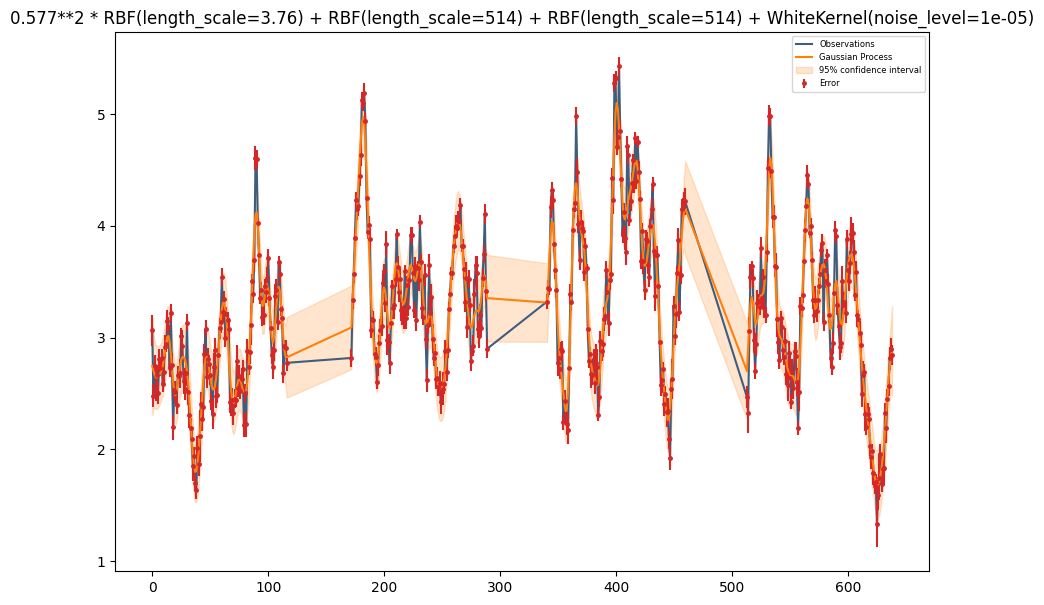

<ipython-input-110-0ae14b276f41>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k':k,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


535464900.0
kernals: 1**2 * RBF(length_scale=0.1) + ExpSineSquared(length_scale=0.1, periodicity=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 481


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 0.629**2 * RBF(length_scale=4.01) + ExpSineSquared(length_scale=99.4, periodicity=0.00397) + WhiteKernel(noise_level=1e-05)
log_likelihood -182.32259377075206
training datapoint 481
K 5
a= 364.64518754150413
aa= 30.879336350528806
Bayesian Information Criterion (BIC): 395.52452389203296
AIC= 374.64518754150413
(2 * k * (k + 1))= 60
(n - k - 1)= 475
Corrected Akaike Information Criterion (AICc): 0.9150425000873771
Mean Squared Error (MSE): 0.041700706544611076
R-squared value: 0.9180211952351683
[2.82365381 2.74450785 2.68683475 2.65485739 2.64587827 2.65257137
 2.66759772 2.68803185 2.71685799 2.76023616 2.82167701 2.8963123
 2.96882907 3.01699583 3.01985382 2.96708097 2.86511963 2.73689506
 2.61477092 2.5294661  2.49954169 2.52585003 2.59307442 2.67721757
 2.7552006  2.81198935 2.84229232 2.84701409 2.8275265  2.78175781
 2.70458358 2.59206483 2.44663627 2.27989243 2.11124305 1.96316821
 1.85550698 1.80129894 1.80542291 1.86562191 1.97444725 2.12067504

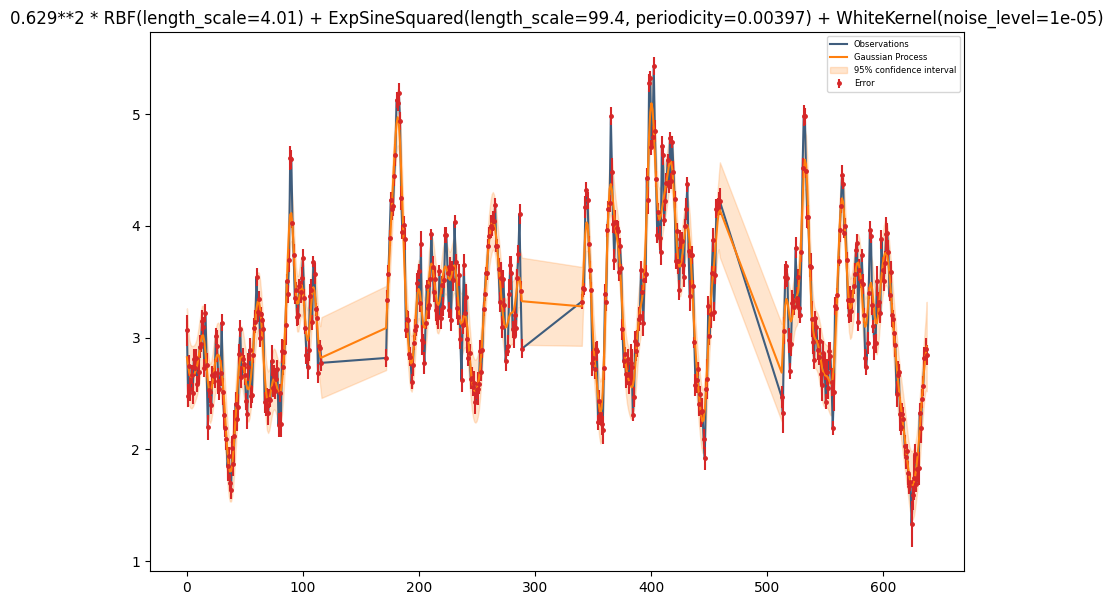

<ipython-input-110-0ae14b276f41>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k':k,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


535464900.0
kernals: 1**2 * RBF(length_scale=0.4) + ExpSineSquared(length_scale=0.0001, periodicity=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 481


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 0.577**2 * RBF(length_scale=3.77) + ExpSineSquared(length_scale=0.031, periodicity=1e+05) + WhiteKernel(noise_level=1e-05)
log_likelihood -178.92407688688843
training datapoint 481
K 5
a= 357.84815377377686
aa= 30.879336350528806
Bayesian Information Criterion (BIC): 388.7274901243057
AIC= 367.84815377377686
(2 * k * (k + 1))= 60
(n - k - 1)= 475
Corrected Akaike Information Criterion (AICc): 0.9007329553132144
Mean Squared Error (MSE): 0.04051363723921775
R-squared value: 0.9203548372976849
[2.74736568 2.70608226 2.66995276 2.6478088  2.64207759 2.6490118
 2.66267694 2.68023756 2.70488693 2.74396089 2.80280872 2.87796003
 2.95405416 3.0072057  3.01399958 2.96214074 2.85763485 2.72478313
 2.59849431 2.51192414 2.48464615 2.51641718 2.58911332 2.67563635
 2.75128989 2.80201299 2.82570789 2.82688988 2.80877839 2.76828237
 2.69715141 2.58830391 2.44295101 2.27387389 2.10297047 1.95475406
 1.84944288 1.79876488 1.80551769 1.86582523 1.97198542 2.11405214
 2

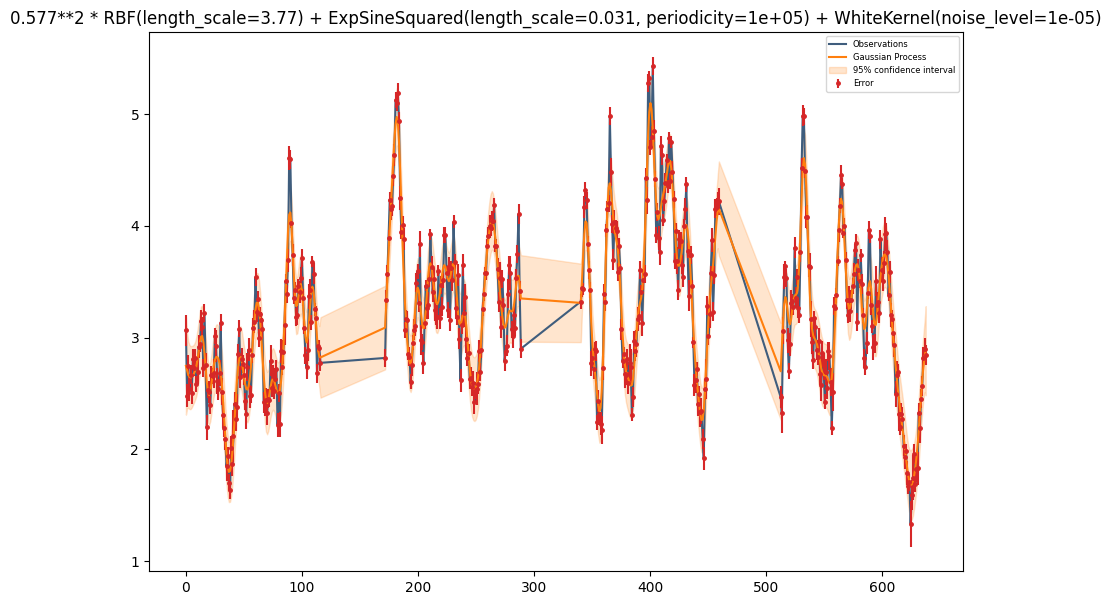

535464900.0


<ipython-input-110-0ae14b276f41>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k':k,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)


In [110]:
# Plotting
for i, kernel in enumerate(kernels):
  print('kernals:',kernel)
  fig, box2 = plt.subplots()   # create the figure and the first axes object
  juldate_zero, AICc, BIC, log_likelihood,final_kernal_value, k = process_and_plot('fvar_soft_dt1000_combined.dat', box2,kernel)  # process and plot the first data file on the first axes object
  plt.legend(loc='upper right', fontsize="6")  # add a legend to the plot
  name= "Boxplot2_"+str(final_kernal_value)+".png"
  plt.savefig(name)
  plt.show()  # display the plot
  Result_Table_box2 = Result_Table_box2.append({'Kernel': str(final_kernal_value), 'k':k,'log_likelihood': log_likelihood,'BIC': BIC, 'AICc': AICc}, ignore_index=True)
  print(juldate_zero)

In [111]:
Result_Table_box2.to_csv("gp_Result_Table_box2.csv")
Result_Table_box2

Kernel  k  log_likelihood  \
0  0.577**2 * RBF(length_scale=3.77) + RBF(length...  4     -178.923967   
1  3.18**2 * RBF(length_scale=1e+05) + Matern(len...  4     -179.103820   
2  2.49**2 * RBF(length_scale=8.34) + WhiteKernel...  3     -248.518426   
3  0.577**2 * RBF(length_scale=3.77) + RBF(length...  4     -178.923967   
4  0.577**2 * RBF(length_scale=3.76) + RBF(length...  5     -176.703895   
5  0.629**2 * RBF(length_scale=4.01) + ExpSineSqu...  5     -182.322594   
6  0.577**2 * RBF(length_scale=3.77) + ExpSineSqu...  5     -178.924077   

          BIC      AICc  
0  382.551403  0.852622  
1  382.911109  0.853377  
2  515.564454  1.104899  
3  382.551403  0.852622  
4  384.287125  0.891385  
5  395.524524  0.915043  
6  388.727490  0.900733

In [112]:
Result_Table_box3 = pd.DataFrame(columns=['Kernel','k','log_likelihood', 'BIC', 'AICc'])

kernals: 1**2 * RBF(length_scale=0.14) + RBF(length_scale=0.01) + WhiteKernel(noise_level=0.01)
Number of training data points: 118


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 0.439**2 * RBF(length_scale=5.21) + RBF(length_scale=9.36e+04) + WhiteKernel(noise_level=1e-05)
log_likelihood -21.06316189030308
training datapoint 118
K 4
a= 42.12632378060616
aa= 19.08273849786266
Bayesian Information Criterion (BIC): 61.20906227846882
AIC= 50.12632378060616
(2 * k * (k + 1))= 40
(n - k - 1)= 113
Corrected Akaike Information Criterion (AICc): 0.7975780865540368
Mean Squared Error (MSE): 0.027112203438407926
R-squared value: 0.8749485961459467
[2.82191949 2.9019546  2.98164328 3.05030887 3.09845966 3.12000693
 3.11384547 3.08427529 3.04003957 2.99215351 2.95107505 2.92399187
 2.91298894 2.91461208 2.92093233 2.92177492 2.90744651 2.87118005
 2.81064716 2.72821509 2.63003157 2.52436975 2.41984172 2.32404348
 2.24295582 2.18109182 2.14208026 2.12921629 2.14555255 2.19332592
 2.2728321  2.38115031 2.51126889 2.6521058  2.78966261 2.90918161
 2.99782115 3.04715429 3.05481096 3.02482183 2.96659937 2.8928745
 2.81716608 2.75142103 2.7043304

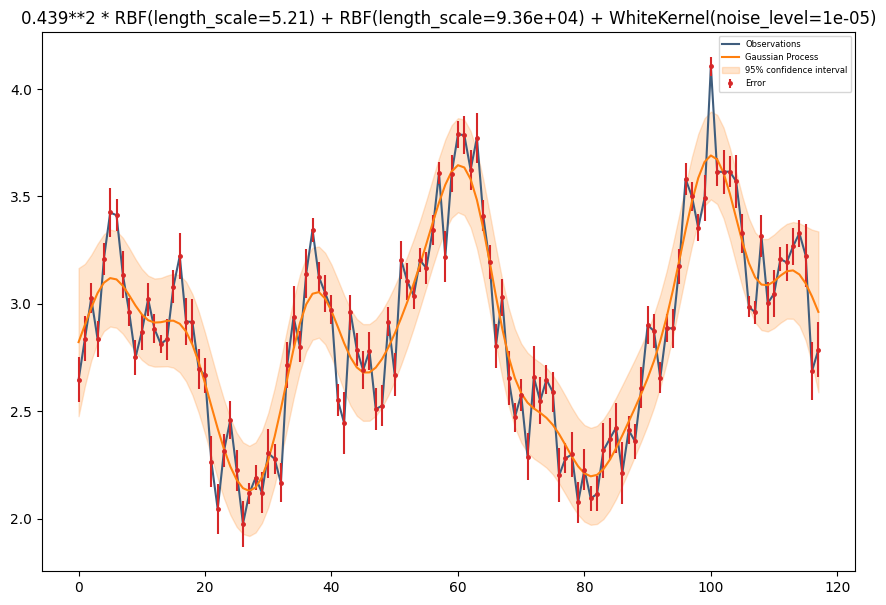

<ipython-input-113-5abf3972bc73>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': k,'log_likelihood':log_likelihood, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


537700900.0
kernals: 1**2 * RBF(length_scale=0.14) + Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.01)
Number of training data points: 118


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 0.439**2 * RBF(length_scale=5.21) + Matern(length_scale=1e+05, nu=1.5) + WhiteKernel(noise_level=1e-05)
log_likelihood -21.0631665353218
training datapoint 118
K 4
a= 42.1263330706436
aa= 19.08273849786266
Bayesian Information Criterion (BIC): 61.20907156850626
AIC= 50.1263330706436
(2 * k * (k + 1))= 40
(n - k - 1)= 113
Corrected Akaike Information Criterion (AICc): 0.7975781687667575
Mean Squared Error (MSE): 0.027112055877283
R-squared value: 0.8749492767518543
[2.82191804 2.90195333 2.98164269 3.0503092  3.09846081 3.12000849
 3.11384687 3.08427599 3.04003923 2.99215214 2.95107301 2.92398975
 2.91298737 2.91461152 2.92093294 2.92177645 2.90744849 2.87118186
 2.8106483  2.72821533 2.63003103 2.52436883 2.41984095 2.32404334
 2.24295656 2.18109335 2.14208219 2.1292181  2.14555375 2.1933262
 2.27283149 2.38114913 2.51126766 2.65210503 2.78966262 2.90918244
 2.99782254 3.04715578 3.05481209 3.02482224 2.96659896 2.89287341
 2.81716464 2.75141964 2.70432

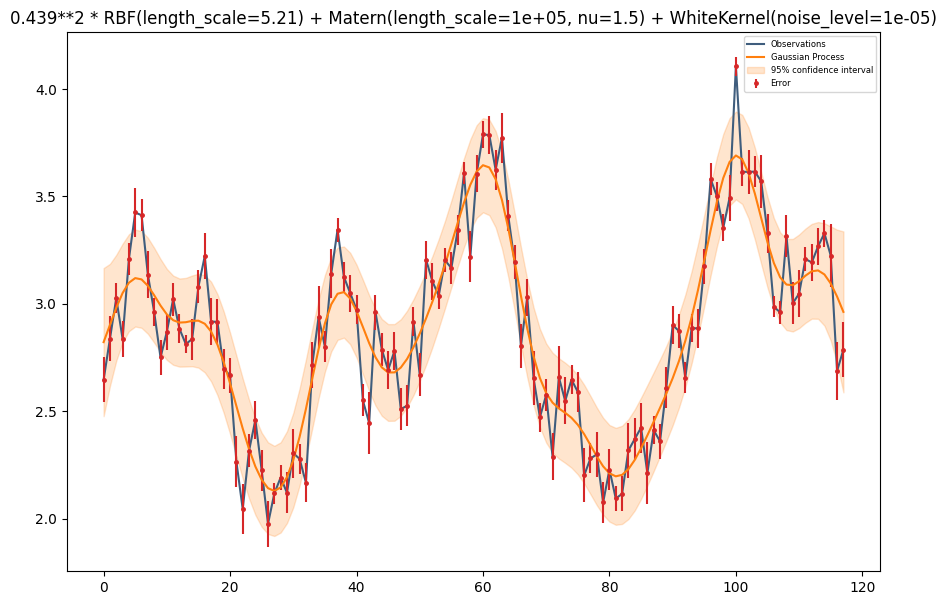

<ipython-input-113-5abf3972bc73>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': k,'log_likelihood':log_likelihood, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


537700900.0
kernals: 1**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)
Number of training data points: 118


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 2.21**2 * RBF(length_scale=10.8) + WhiteKernel(noise_level=1e-05)
log_likelihood -31.978564596682418
training datapoint 118
K 3
a= 63.957129193364835
aa= 14.312053873396994
Bayesian Information Criterion (BIC): 78.26918306676183
AIC= 69.95712919336484
(2 * k * (k + 1))= 24
(n - k - 1)= 114
Corrected Akaike Information Criterion (AICc): 0.8241853438014459
Mean Squared Error (MSE): 0.03493828698721358
R-squared value: 0.8388518348966985
[2.79652234 2.89620538 2.97138237 3.02385396 3.05641647 3.07255133
 3.07605145 3.07062275 3.05950341 3.04514402 3.02898692 3.0113732
 2.99159225 2.96807244 2.93869459 2.90119407 2.85360527 2.79469458
 2.72432706 2.64371743 2.55552733 2.46378796 2.37364667 2.29095711
 2.22175161 2.17164994 2.14526786 2.14569136 2.17407736 2.22942935
 2.30857857 2.40637987 2.51610826 2.63002072 2.7400301  2.83842542
 2.91856815 2.97549597 3.00637504 3.01075695 2.99061641 2.95016676
 2.89547223 2.83389468 2.77342736 2.72197767 2.68666415 2.67

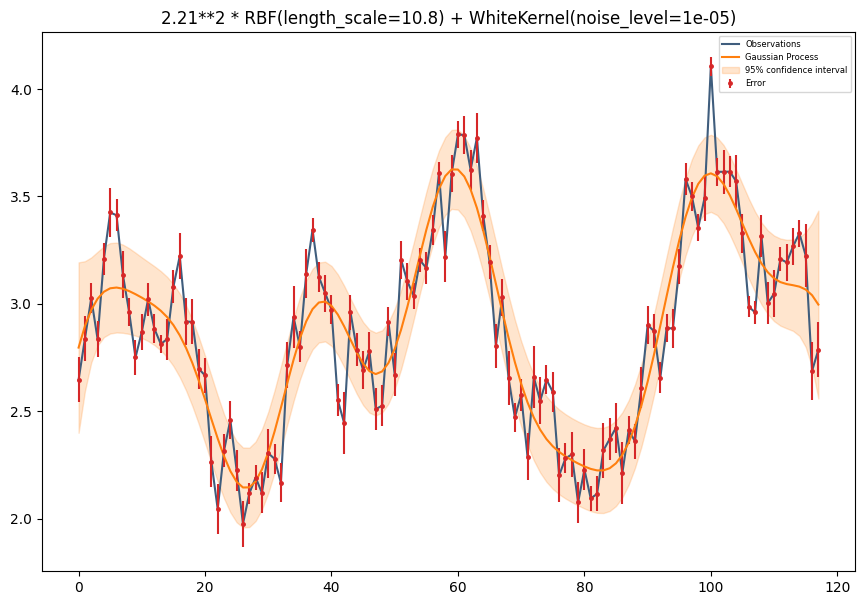

<ipython-input-113-5abf3972bc73>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': k,'log_likelihood':log_likelihood, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


537700900.0
kernals: 1**2 * RBF(length_scale=0.24) + RBF(length_scale=0.14) + WhiteKernel(noise_level=0.01)
Number of training data points: 118


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 0.439**2 * RBF(length_scale=5.21) + RBF(length_scale=1e+05) + WhiteKernel(noise_level=1e-05)
log_likelihood -21.063161532826797
training datapoint 118
K 4
a= 42.126323065653594
aa= 19.08273849786266
Bayesian Information Criterion (BIC): 61.20906156351626
AIC= 50.126323065653594
(2 * k * (k + 1))= 40
(n - k - 1)= 113
Corrected Akaike Information Criterion (AICc): 0.7975780802270229
Mean Squared Error (MSE): 0.027112057538890275
R-squared value: 0.8749492690879135
[2.8219185  2.90195361 2.98164284 3.05030926 3.09846082 3.1200085
 3.11384688 3.08427602 3.04003928 2.99215221 2.95107308 2.92398982
 2.91298744 2.91461158 2.92093298 2.92177649 2.90744852 2.8711819
 2.81064834 2.72821538 2.63003108 2.52436888 2.419841   2.32404339
 2.2429566  2.18109338 2.14208223 2.12921814 2.14555378 2.19332623
 2.27283153 2.38114917 2.51126769 2.65210506 2.78966264 2.90918246
 2.99782255 3.04715579 3.05481209 3.02482225 2.96659897 2.89287342
 2.81716466 2.75141965 2.70432941

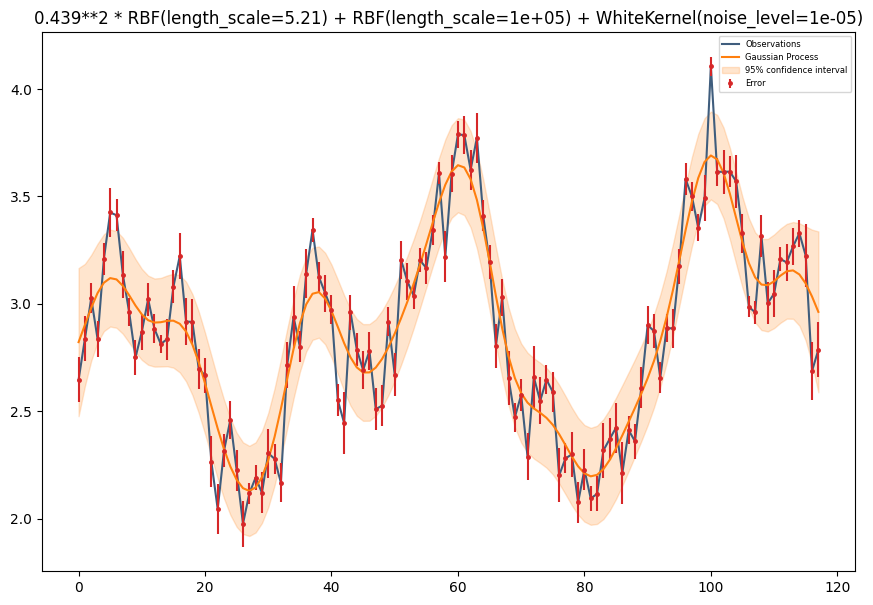

<ipython-input-113-5abf3972bc73>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': k,'log_likelihood':log_likelihood, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


537700900.0
kernals: 1**2 * RBF(length_scale=0.4) + RBF(length_scale=0.2) + RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 118


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 0.00316**2 * RBF(length_scale=1e+05) + RBF(length_scale=6.99e+03) + RBF(length_scale=8.34) + WhiteKernel(noise_level=1e-05)
log_likelihood -25.411199802561953
training datapoint 118
K 5
a= 50.822399605123906
aa= 23.853423122328326
Bayesian Information Criterion (BIC): 74.67582272745223
AIC= 60.822399605123906
(2 * k * (k + 1))= 60
(n - k - 1)= 112
Corrected Akaike Information Criterion (AICc): 1.0787714250457492
Mean Squared Error (MSE): 0.033440218795917895
R-squared value: 0.8457614736066693
[2.83399837 2.91511086 2.98179495 3.03161026 3.06369623 3.07882582
 3.07923875 3.06826768 3.04980405 3.02767866 3.00504995 2.98389623
 2.96469639 2.94635695 2.92640675 2.90143904 2.86774122 2.82202127
 2.76212223 2.6876141  2.60016786 2.50364516 2.40387652 2.30814431
 2.22442834 2.16050607 2.12302099 2.11663977 2.1434093  2.20240065
 2.28969135 2.39869415 2.5207967  2.64623627 2.76510427 2.86835978
 2.94873187 3.00140754 3.02443285 3.01879381 2.98818594 2.93851953

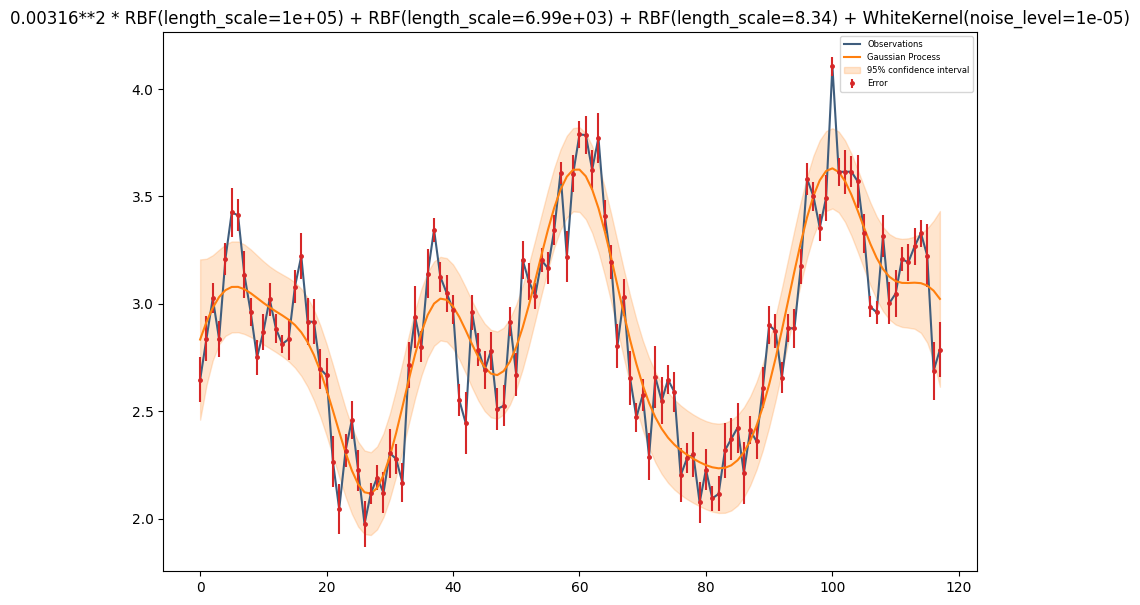

<ipython-input-113-5abf3972bc73>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': k,'log_likelihood':log_likelihood, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


537700900.0
kernals: 1**2 * RBF(length_scale=0.1) + ExpSineSquared(length_scale=0.1, periodicity=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 118


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 2.83**2 * RBF(length_scale=1e+05) + ExpSineSquared(length_scale=0.416, periodicity=109) + WhiteKernel(noise_level=1e-05)
log_likelihood -20.7986093173957
training datapoint 118
K 5
a= 41.5972186347914
aa= 23.853423122328326
Bayesian Information Criterion (BIC): 65.45064175711973
AIC= 51.5972186347914
(2 * k * (k + 1))= 60
(n - k - 1)= 112
Corrected Akaike Information Criterion (AICc): 0.9964037378106375
Mean Squared Error (MSE): 0.03044810529777859
R-squared value: 0.8595621960113605
[3.03861324 3.04239643 3.06540584 3.09540116 3.12030273 3.13082901
 3.12231185 3.09530323 3.05489392 3.00898254 2.96597842 2.93253341
 2.91185336 2.90295897 2.90100572 2.8985064  2.88709817 2.85940544
 2.81058207 2.73924722 2.6477113  2.54156335 2.42881323 2.31882516
 2.22124818 2.14506986 2.09783196 2.08498589 2.10935328 2.17069025
 2.26541242 2.38658805 2.52431797 2.66657694 2.80049637 2.91394796
 2.99718109 3.04420942 3.05366091 3.02889954 2.97737731 2.90934074
 2.836155

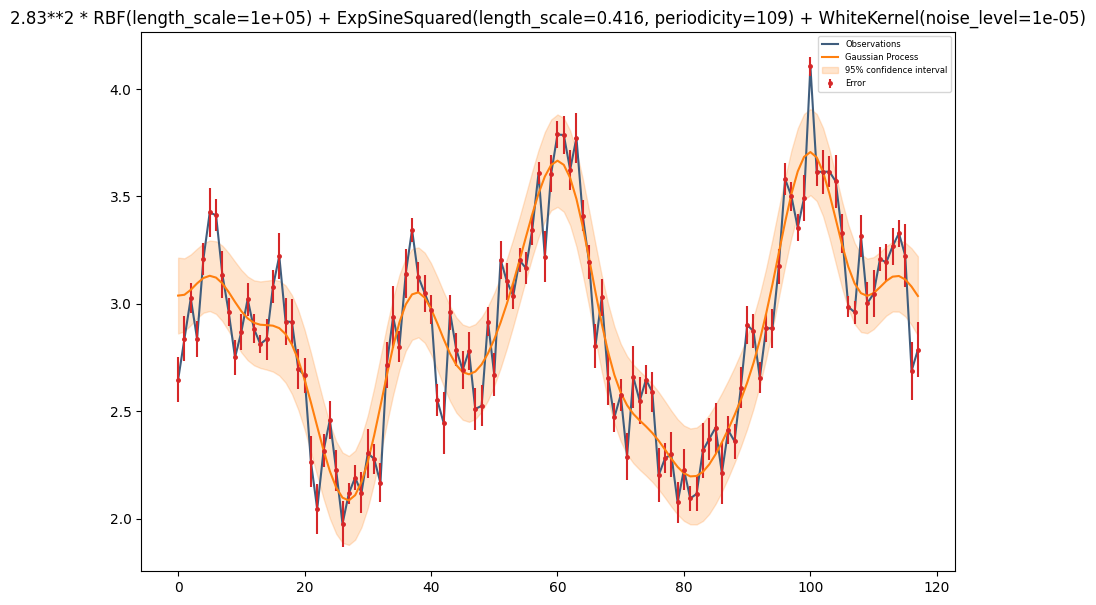

<ipython-input-113-5abf3972bc73>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': k,'log_likelihood':log_likelihood, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


537700900.0
kernals: 1**2 * RBF(length_scale=0.4) + ExpSineSquared(length_scale=0.0001, periodicity=0.1) + WhiteKernel(noise_level=0.01)
Number of training data points: 118


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


final values of the kernals are: 2.69**2 * RBF(length_scale=620) + ExpSineSquared(length_scale=0.5, periodicity=94.8) + WhiteKernel(noise_level=1e-05)
log_likelihood -18.916903769925767
training datapoint 118
K 5
a= 37.833807539851534
aa= 23.853423122328326
Bayesian Information Criterion (BIC): 61.68723066217986
AIC= 47.833807539851534
(2 * k * (k + 1))= 60
(n - k - 1)= 112
Corrected Akaike Information Criterion (AICc): 0.9628018530343887
Mean Squared Error (MSE): 0.02966114955524053
R-squared value: 0.8631919238790698
[2.79454316 2.92919254 3.05053179 3.14776637 3.21193723 3.23779906
 3.22510796 3.17897275 3.10912365 3.02820085 2.94940055 2.88397655
 2.83913795 2.8167953  2.81341163 2.82096208 2.82876134 2.82574247
 2.80270262 2.75407902 2.67895883 2.58121425 2.46883762 2.35268669
 2.24491443 2.1573519  2.1000567  2.08016406 2.10110977 2.16225079
 2.25888988 2.38270391 2.52256314 2.66569842 2.79912203 2.91114729
 2.99280201 3.0389144  3.04868089 3.02560535 2.97681313 2.91186435
 2.841

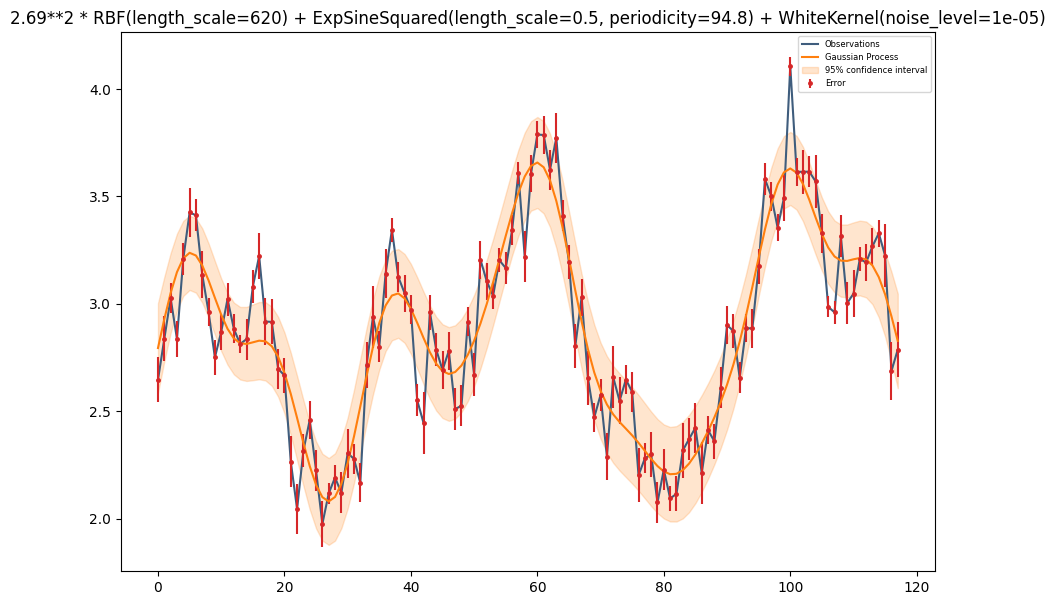

537700900.0


<ipython-input-113-5abf3972bc73>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': k,'log_likelihood':log_likelihood, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


In [113]:
# Plotting Box3
for i, kernel in enumerate(kernels):
  print('kernals:',kernel)
  fig, box3 = plt.subplots()   # create the figure and the first axes object
  juldate_zero, AICc, BIC, log_likelihood, final_kernal_value, k = process_and_plot(data_files[-1], box3,kernel)  # process and plot the first data file on the first axes object
  plt.legend(loc='upper right', fontsize="6")  # add a legend to the plot
  name= "Boxplot3_"+str(final_kernal_value)+".png"
  plt.savefig(name)
  plt.show()  # display the plot
  Result_Table_box3 = Result_Table_box3.append({'Kernel': str(final_kernal_value), 'k': k,'log_likelihood':log_likelihood, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)
  print(juldate_zero)

In [114]:
Result_Table_box3.to_csv("gp_Result_Table_box3.csv")
Result_Table_box3

Kernel  k  log_likelihood  \
0  0.439**2 * RBF(length_scale=5.21) + RBF(length...  4      -21.063162   
1  0.439**2 * RBF(length_scale=5.21) + Matern(len...  4      -21.063167   
2  2.21**2 * RBF(length_scale=10.8) + WhiteKernel...  3      -31.978565   
3  0.439**2 * RBF(length_scale=5.21) + RBF(length...  4      -21.063162   
4  0.00316**2 * RBF(length_scale=1e+05) + RBF(len...  5      -25.411200   
5  2.83**2 * RBF(length_scale=1e+05) + ExpSineSqu...  5      -20.798609   
6  2.69**2 * RBF(length_scale=620) + ExpSineSquar...  5      -18.916904   

         BIC      AICc  
0  61.209062  0.797578  
1  61.209072  0.797578  
2  78.269183  0.824185  
3  61.209062  0.797578  
4  74.675823  1.078771  
5  65.450642  0.996404  
6  61.687231  0.962802

<Figure size 1200x600 with 0 Axes>

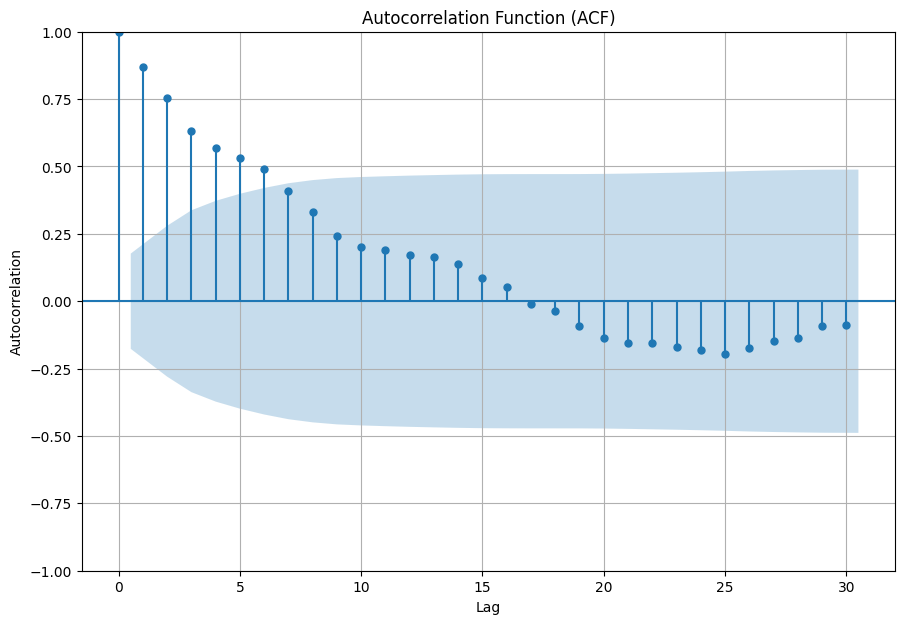

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

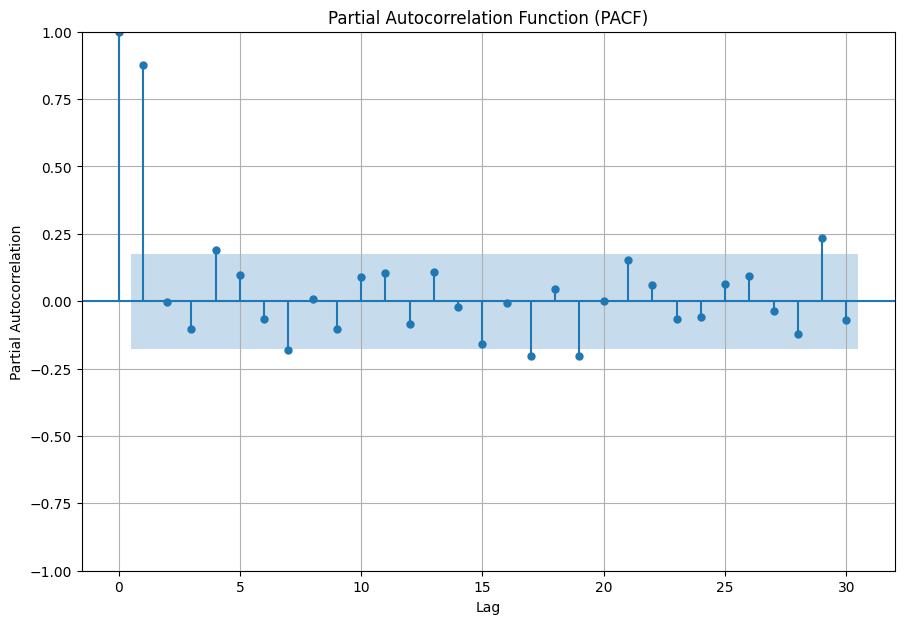

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the data
data = np.genfromtxt(data_files[0])
juldate = data[:, 1]
juldate_zero = juldate_zero if juldate_zero is not None else juldate.min()
tsec = juldate - juldate_zero
t = tsec / 1000.0
y = data[:, 2]
y_error = data[:, 3].T

# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(y, lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(y, lags=30, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()








In [ ]:
def process_and_plot_ARMA(data_file, box, p, q, juldate_zero=None, col1=None, col2=None, sigma=y_error):
    data = np.genfromtxt(data_file)
    juldate = data[:, 1]
    juldate_zero = juldate_zero if juldate_zero is not None else juldate.min()
    tsec = juldate - juldate_zero
    t = tsec / 1000.0
    y = data[:, 2]
    y_error = data[:, 3].T

    print(t.shape)

    X = t.reshape(-1, 1)
    y = y.reshape(-1, 1)
    num_training_data = t.shape[0]
    print("Number of training data points:", num_training_data)

    print(X.shape)
    model = ARIMA(y, order=(p, 0, q))  # Use 'y' instead of 't' for ARIMA
    model_fit = model.fit()
    y_pred = model_fit.predict(start=0, end=num_training_data-1)

    # Calculate mean squared error
    mse = mean_squared_error(y, y_pred)
    print("Mean Squared Error (MSE):", mse)

    # Calculate R-squared value
    r2 = r2_score(y, y_pred)
    print("R-squared value:", r2)

    box.plot(t, y, color=col1, linewidth=1.5, label='Observations')
    plt.errorbar(
        X.flatten(),
        y.flatten(),
        yerr=y_error.flatten(),
        linestyle="None",
        color="tab:red",
        marker=".",
        markersize=5,
        label="Error",
    )  # plot error bars representing noise in the data
    box.plot(t, y_pred, color=col2, linewidth=1.5, label='ARMA Model')
    plt.legend(loc='upper right', fontsize="6")
    plt.title("order (" + str(p) + ", 0, " + str(q)+')')  # Corrected line

    return juldate_zero

In [ ]:
def process_and_plot_ARMA(data_file, box, p, q, juldate_zero=None, col1=None, col2=None, sigma=y_error):
    data = np.genfromtxt(data_file)
    juldate = data[:, 1]
    juldate_zero = juldate_zero if juldate_zero is not None else juldate.min()
    tsec = juldate - juldate_zero
    t = tsec / 1000.0
    y = data[:, 2]
    y_error = data[:, 3].T

    print(t.shape)

    X = t.reshape(-1, 1)
    y = y.reshape(-1, 1)
    num_training_data = t.shape[0]
    print("Number of training data points:", num_training_data)

    print(X.shape)
    model = ARIMA(y, order=(p, 0, q))  # Use 'y' instead of 't' for ARIMA
    model_fit = model.fit()
    y_pred = model_fit.predict(start=0, end=num_training_data-1)

    # Calculate mean squared error
    mse = mean_squared_error(y, y_pred)
    print("Mean Squared Error (MSE):", mse)

    # Calculate R-squared value
    r2 = r2_score(y, y_pred)
    print("R-squared value:", r2)

    # Calculate BIC and AICc
    n = num_training_data  # Number of data points
    k = p + q + 1  # Number of model parameters
    log_likelihood = -0.5 * n * np.log(2 * np.pi * mse) - 0.5 * n
    bic = -2 * log_likelihood + k * np.log(n)


    # Calculate AICc
    aic = 2 * k - 2 * log_likelihood

    aicc = aic + (2 * k * (k + 1)) / (n - k - 1)
    print("Bayesian Information Criterion (BIC):", bic)
    print("Corrected Akaike Information Criterion (AICc):", aicc)

    box.plot(t, y, color=col1, linewidth=1.5, label='Observations')
    plt.errorbar(
        X.flatten(),
        y.flatten(),
        yerr=y_error.flatten(),
        linestyle="None",
        color="tab:red",
        marker=".",
        markersize=5,
        label="Error",
    )  # plot error bars representing noise in the data
    box.plot(t, y_pred, color=col2, linewidth=1.5, label='ARMA Model')
    plt.legend(loc='upper right', fontsize="6")
    order= "order (" + str(p) + ", 0, " + str(q)+')'
    plt.title(order)  # Corrected line

    return juldate_zero, bic, aicc, order

In [ ]:
ARMA_Result_Table_box1 = pd.DataFrame(columns=['Order', 'BIC', 'AICc'])

(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.8471009724048163
R-squared value: -2.930056197669728e-11
Bayesian Information Criterion (BIC): 333.4610118300702
Corrected Akaike Information Criterion (AICc): 330.68188532593746


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


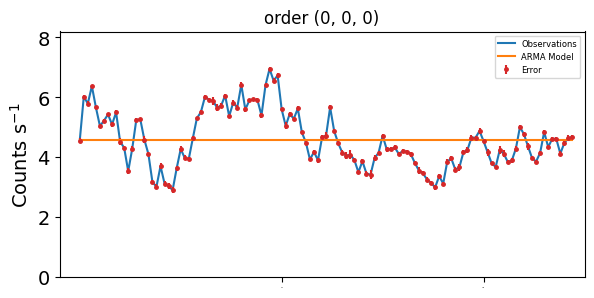

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.42317348072054456
R-squared value: 0.5004450537559815
Bayesian Information Criterion (BIC): 252.9065609941404
Corrected Akaike Information Criterion (AICc): 247.38219228339554


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


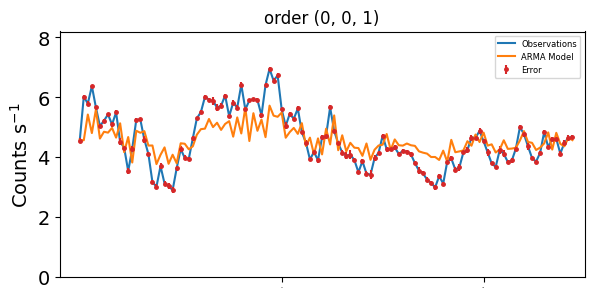

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.27902016744903096
R-squared value: 0.6706175809654635
Bayesian Information Criterion (BIC): 206.48947278828138
Corrected Akaike Information Criterion (AICc): 198.25460039443303


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


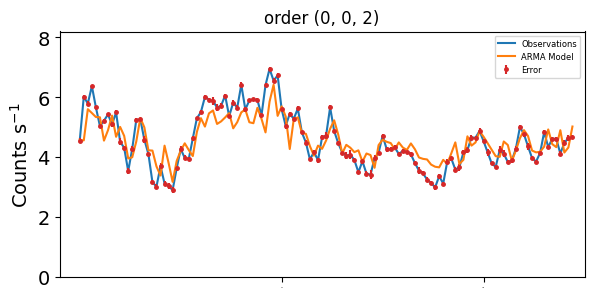

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.23845061668220197
R-squared value: 0.7185098064375295
Bayesian Information Criterion (BIC): 191.97567168221616
Corrected Akaike Information Criterion (AICc): 181.06591731157394


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


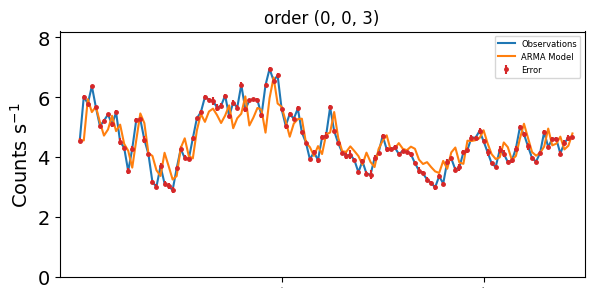

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.22153682878353248
R-squared value: 0.7384764791839306
Bayesian Information Criterion (BIC): 187.7383296351452
Corrected Akaike Information Criterion (AICc): 174.19022837110364


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


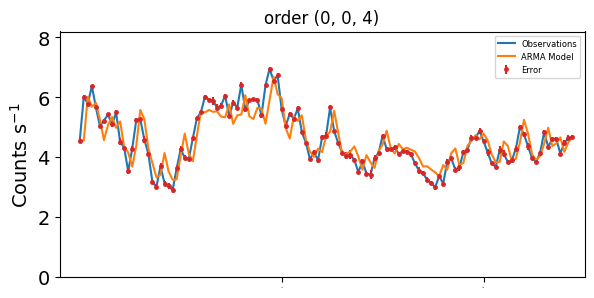

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.21792241053739014
R-squared value: 0.7427432884121001
Bayesian Information Criterion (BIC): 190.52719337561877
Corrected Akaike Information Criterion (AICc): 174.37822517441873


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


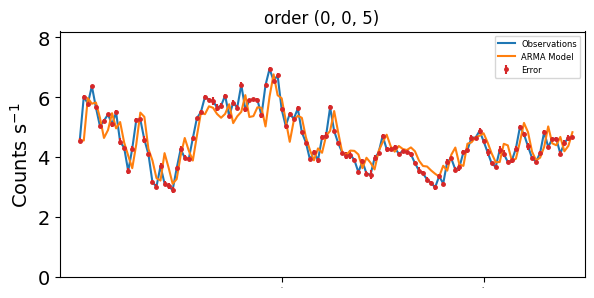

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.21274740397138997
R-squared value: 0.7488523671816127
Bayesian Information Criterion (BIC): 192.3832548520697
Corrected Akaike Information Criterion (AICc): 173.67187740794105


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


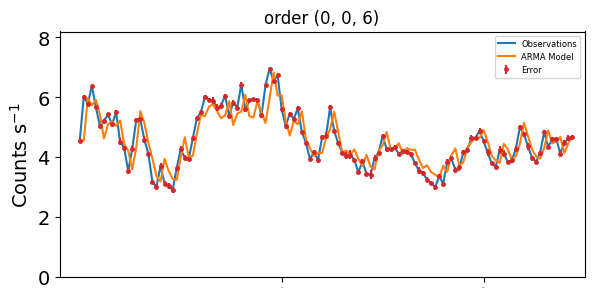

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.20810704727117998
R-squared value: 0.7543302934873429
Bayesian Information Criterion (BIC): 165.6098180760363
Corrected Akaike Information Criterion (AICc): 160.08544936529145


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


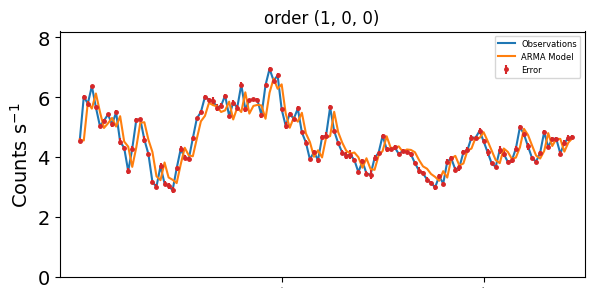

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.20810520483631792
R-squared value: 0.7543324684758297
Bayesian Information Criterion (BIC): 170.42091347025064
Corrected Akaike Information Criterion (AICc): 162.1860410764023


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


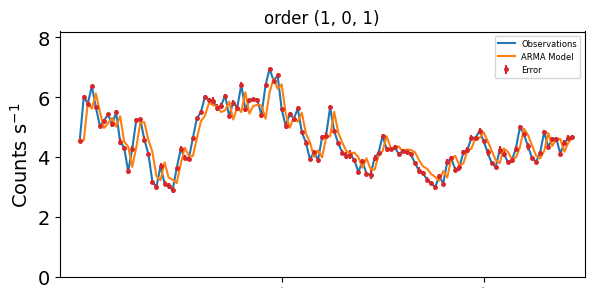

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.20450532538117236
R-squared value: 0.7585821147075315
Bayesian Information Criterion (BIC): 173.08678125872174
Corrected Akaike Information Criterion (AICc): 162.17702688807952


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


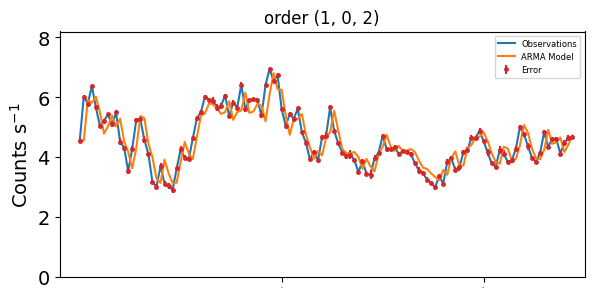

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.20037630016707253
R-squared value: 0.7634564158224257
Bayesian Information Criterion (BIC): 175.39014487847487
Corrected Akaike Information Criterion (AICc): 161.84204361443332


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


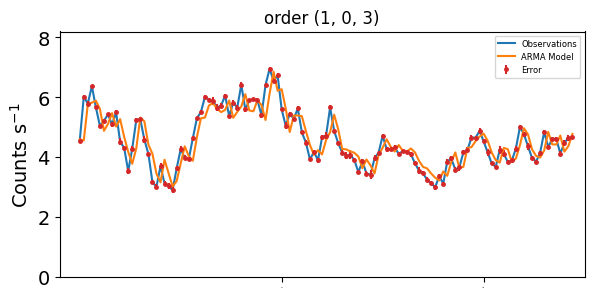

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.19937864375637748
R-squared value: 0.7646341460378593
Bayesian Information Criterion (BIC): 179.58839314551923
Corrected Akaike Information Criterion (AICc): 163.4394249443192


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


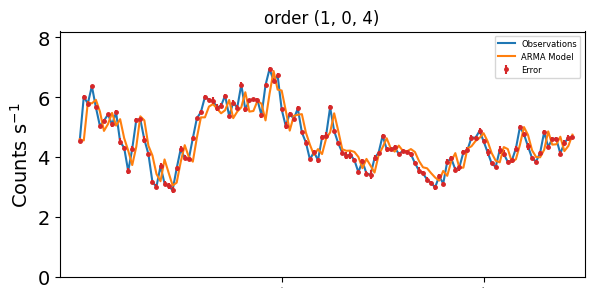

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.19889002416867138
R-squared value: 0.7652109599049632
Bayesian Information Criterion (BIC): 184.09876998108373
Corrected Akaike Information Criterion (AICc): 165.38739253695508


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


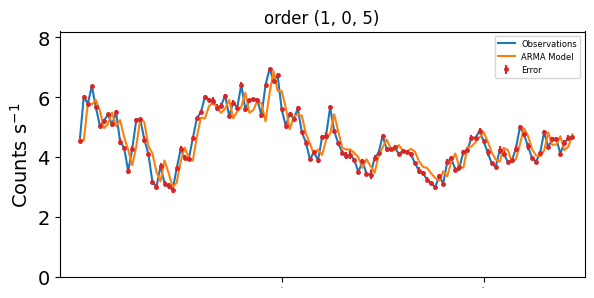

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.19625544575015336
R-squared value: 0.768321071337271
Bayesian Information Criterion (BIC): 187.27075865124112
Corrected Akaike Information Criterion (AICc): 166.03644170299864


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


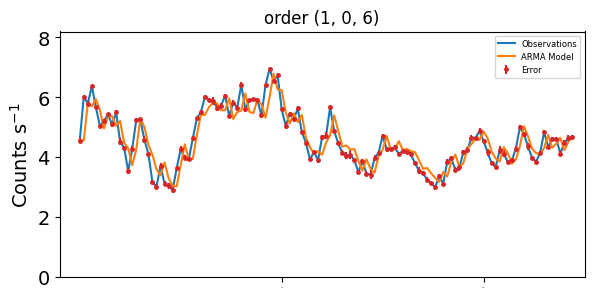

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.20810481059819003
R-squared value: 0.7543329338726841
Bayesian Information Criterion (BIC): 170.4206804566857
Corrected Akaike Information Criterion (AICc): 162.18580806283734


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


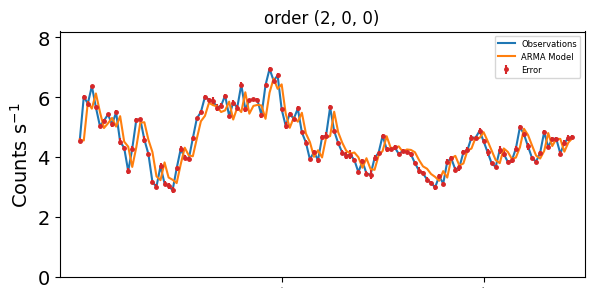

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.20483102742827086
R-squared value: 0.7581976244782458
Bayesian Information Criterion (BIC): 173.28251936002934
Corrected Akaike Information Criterion (AICc): 162.37276498938712


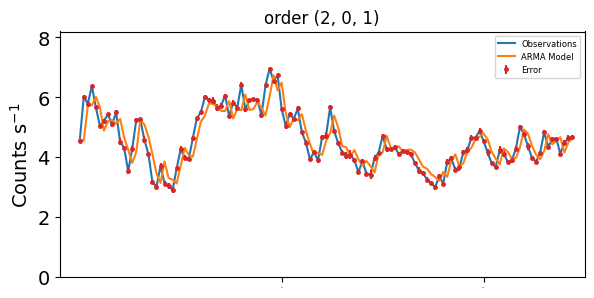

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.20306193796101532
R-squared value: 0.7602860289600458
Bayesian Information Criterion (BIC): 177.02776024077062
Corrected Akaike Information Criterion (AICc): 163.47965897672907


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


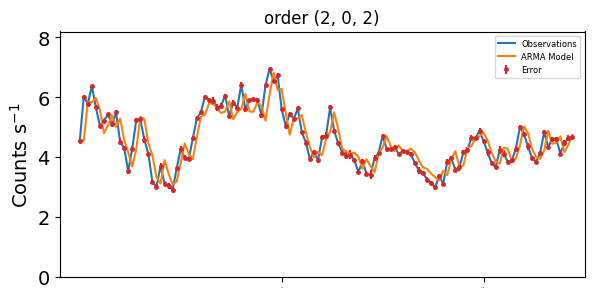

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.19983560166407985
R-squared value: 0.7640947086831618
Bayesian Information Criterion (BIC): 179.86997551808875
Corrected Akaike Information Criterion (AICc): 163.72100731688872


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


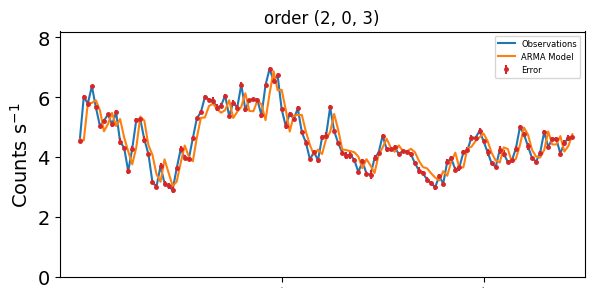

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.1992786633021497
R-squared value: 0.7647521726456519
Bayesian Information Criterion (BIC): 184.33888242639978
Corrected Akaike Information Criterion (AICc): 165.62750498227112


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


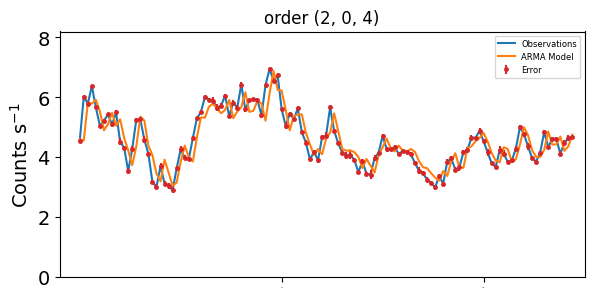

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.19727383107897015
R-squared value: 0.7671188707000134
Bayesian Information Criterion (BIC): 187.9073652898809
Corrected Akaike Information Criterion (AICc): 166.6730483416384


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


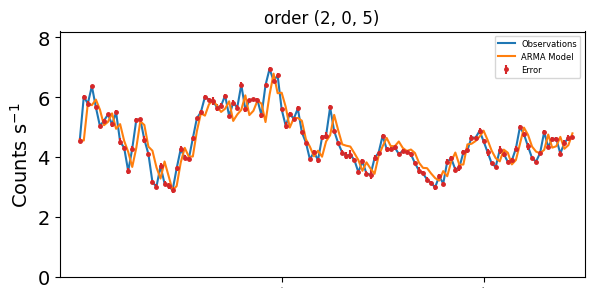

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.1914446254498391
R-squared value: 0.7740002293800223
Bayesian Information Criterion (BIC): 189.03026742550088
Corrected Akaike Information Criterion (AICc): 165.3135285811314


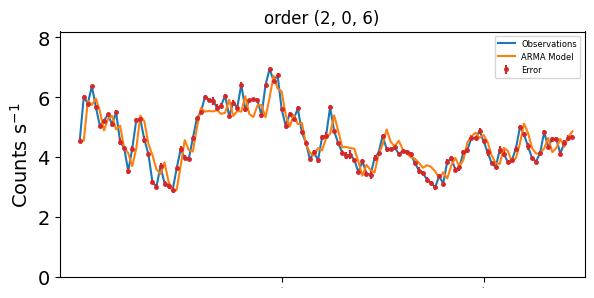

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.20616487128830138
R-squared value: 0.7566230260495803
Bayesian Information Criterion (BIC): 174.08088922844675
Corrected Akaike Information Criterion (AICc): 163.17113485780453


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


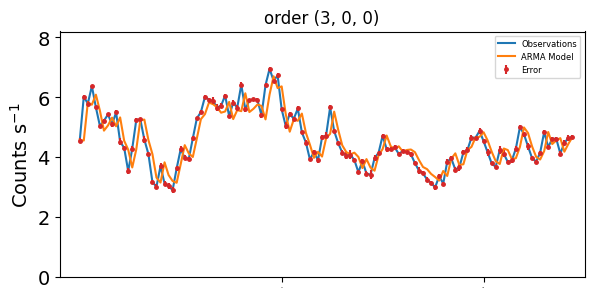

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.20342461061628084
R-squared value: 0.759857895045565
Bayesian Information Criterion (BIC): 177.24724474076524
Corrected Akaike Information Criterion (AICc): 163.6991434767237


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


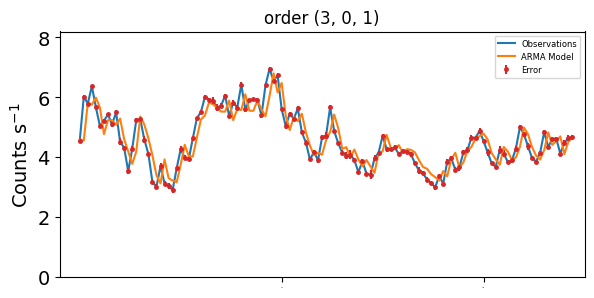

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.2004183396731706
R-squared value: 0.7634067883193667
Bayesian Information Criterion (BIC): 180.22813226989135
Corrected Akaike Information Criterion (AICc): 164.0791640686913


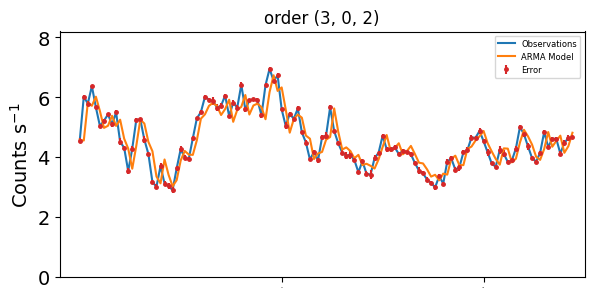

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.197221565904345
R-squared value: 0.7671805695722014
Bayesian Information Criterion (BIC): 183.06258934248655
Corrected Akaike Information Criterion (AICc): 164.3512118983579


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


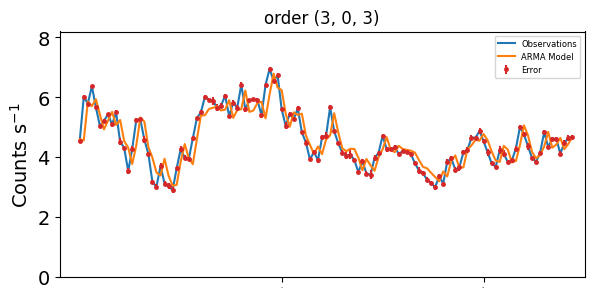

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.18921437717376752
R-squared value: 0.7766330303669052
Bayesian Information Criterion (BIC): 182.77677378814144
Corrected Akaike Information Criterion (AICc): 161.54245683989896


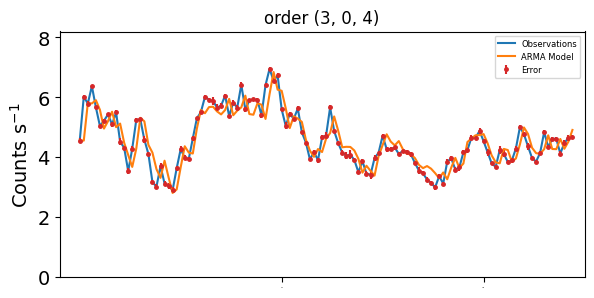

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.18911454120933707
R-squared value: 0.7767508864049523
Bayesian Information Criterion (BIC): 187.5240420172898
Corrected Akaike Information Criterion (AICc): 163.80730317292034


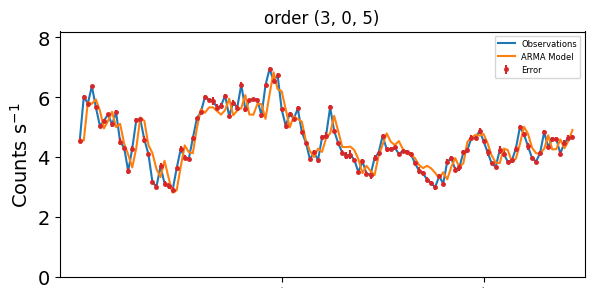

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.1921778974582702
R-squared value: 0.7731346041094351
Bayesian Information Criterion (BIC): 194.31266696113016
Corrected Akaike Information Criterion (AICc): 168.1551091216917


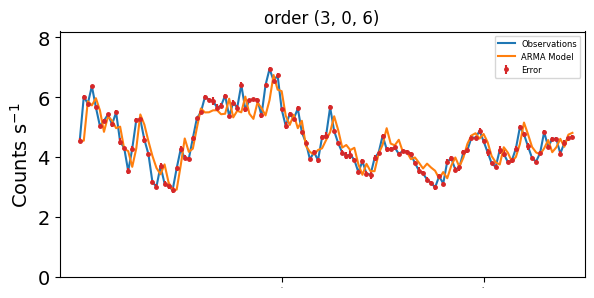

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.20005926106810015
R-squared value: 0.7638306794690388
Bayesian Information Criterion (BIC): 175.1953778742586
Corrected Akaike Information Criterion (AICc): 161.64727661021706


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


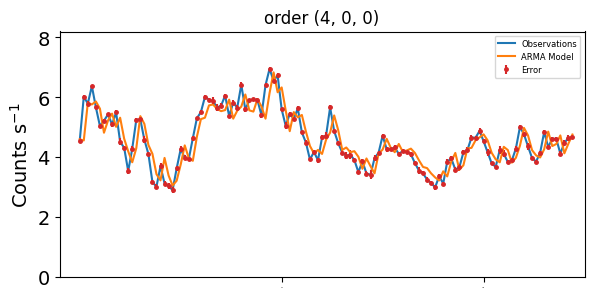

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.19939635403543152
R-squared value: 0.7646132391098407
Bayesian Information Criterion (BIC): 179.59931842587602
Corrected Akaike Information Criterion (AICc): 163.450350224676


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


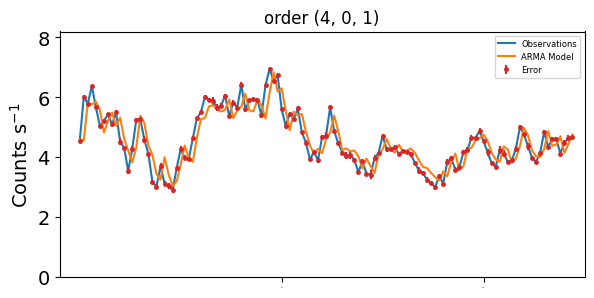

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.19561713732281494
R-squared value: 0.7690745924028236
Bayesian Information Criterion (BIC): 182.05787259133382
Corrected Akaike Information Criterion (AICc): 163.34649514720516


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


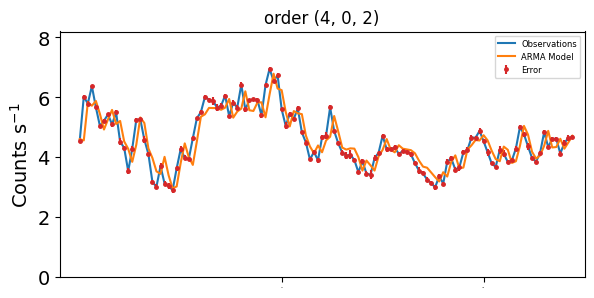

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.20022307187356825
R-squared value: 0.7636373013348975
Bayesian Information Criterion (BIC): 189.73260353338947
Corrected Akaike Information Criterion (AICc): 168.49828658514699


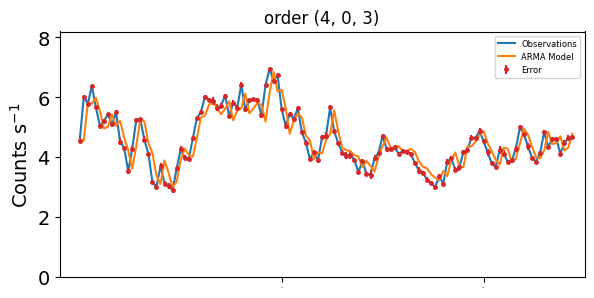

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.19413278689963753
R-squared value: 0.7708268633499422
Bayesian Information Criterion (BIC): 190.74535344949498
Corrected Akaike Information Criterion (AICc): 167.02861460512554


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


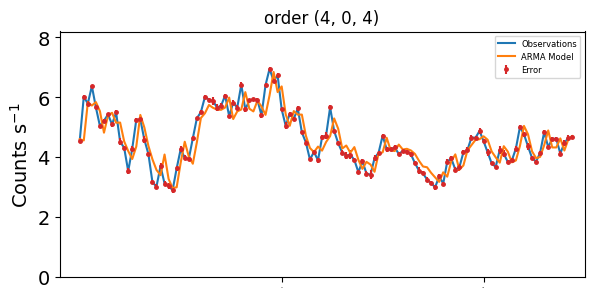

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.18885244650458632
R-squared value: 0.7770602883691766
Bayesian Information Criterion (BIC): 192.16564187772272
Corrected Akaike Information Criterion (AICc): 166.00808403828427


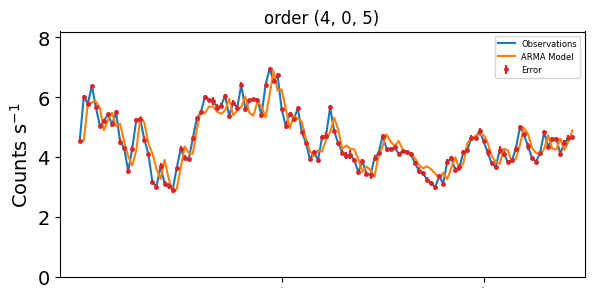

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.18308940309256183
R-squared value: 0.7838635427626084
Bayesian Information Criterion (BIC): 193.16588049173782
Corrected Akaike Information Criterion (AICc): 164.61023096101962


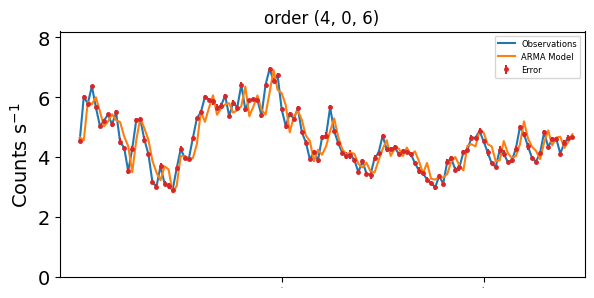

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.1986913483186118
R-squared value: 0.7654454961132047
Bayesian Information Criterion (BIC): 179.16365666936449
Corrected Akaike Information Criterion (AICc): 163.01468846816445


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


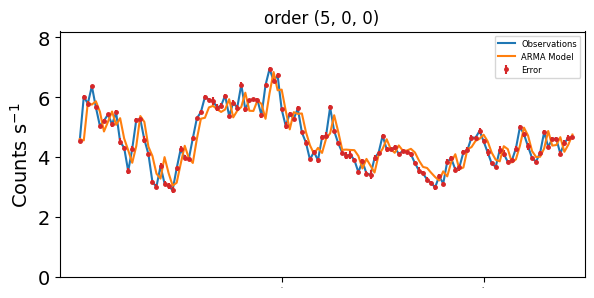

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.19857864749507848
R-squared value: 0.7655785390764499
Bayesian Information Criterion (BIC): 183.90605371730092
Corrected Akaike Information Criterion (AICc): 165.19467627317226


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


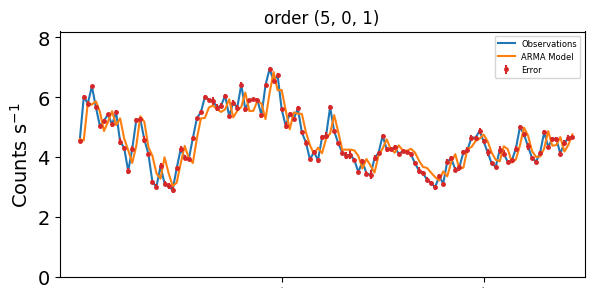

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.1919253798199461
R-squared value: 0.7734327003772444
Bayesian Information Criterion (BIC): 184.52657261134027
Corrected Akaike Information Criterion (AICc): 163.2922556630978


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


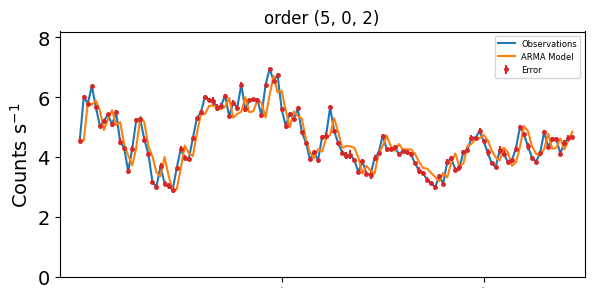

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Squared Error (MSE): 0.19391301357026822
R-squared value: 0.7710863050653163
Bayesian Information Criterion (BIC): 190.60602905855973
Corrected Akaike Information Criterion (AICc): 166.88929021419028


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


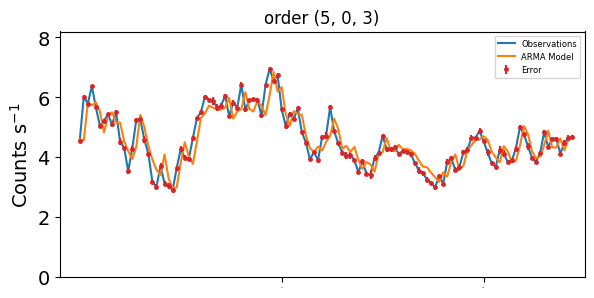

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.19378625572795294
R-squared value: 0.7712359422944641
Bayesian Information Criterion (BIC): 195.33778398630625
Corrected Akaike Information Criterion (AICc): 169.1802261468678


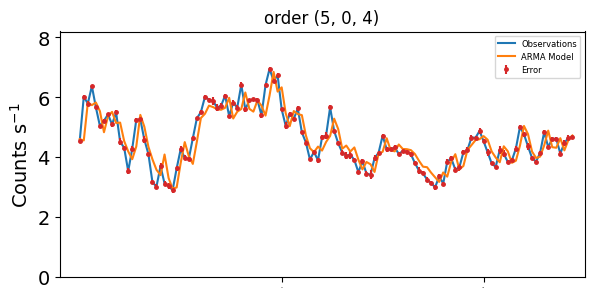

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.18828200633546494
R-squared value: 0.7777336911720546
Bayesian Information Criterion (BIC): 196.60573509274985
Corrected Akaike Information Criterion (AICc): 168.05008556203165


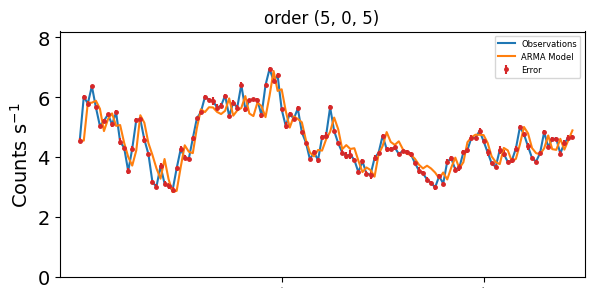

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.18350622195712096
R-squared value: 0.7833714894205043
Bayesian Information Criterion (BIC): 198.25776672531282
Corrected Akaike Information Criterion (AICc): 167.34791809720744


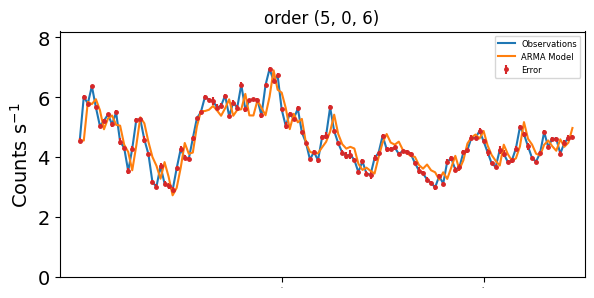

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.1981414078627137
R-squared value: 0.7660946990699112
Bayesian Information Criterion (BIC): 183.6349280414982
Corrected Akaike Information Criterion (AICc): 164.92355059736954


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


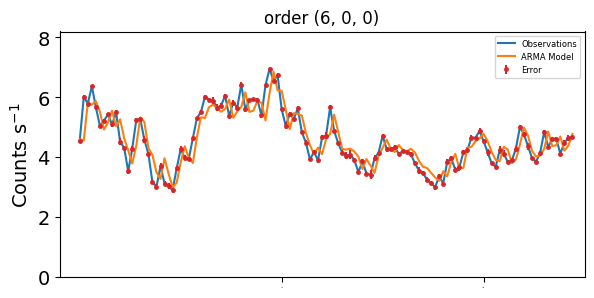

441220800.0
(123,)
Number of training data points: 123
(123, 1)
Mean Squared Error (MSE): 0.1956672949146593
R-squared value: 0.7690153815253961
Bayesian Information Criterion (BIC): 186.90159095788766
Corrected Akaike Information Criterion (AICc): 165.66727400964518


<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


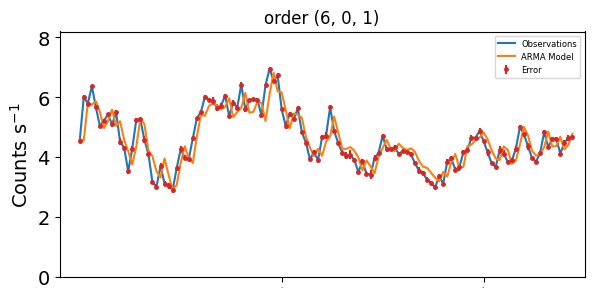

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.1825401291448967
R-squared value: 0.7845119589084686
Bayesian Information Criterion (BIC): 183.1719533048306
Corrected Akaike Information Criterion (AICc): 159.45521446046115


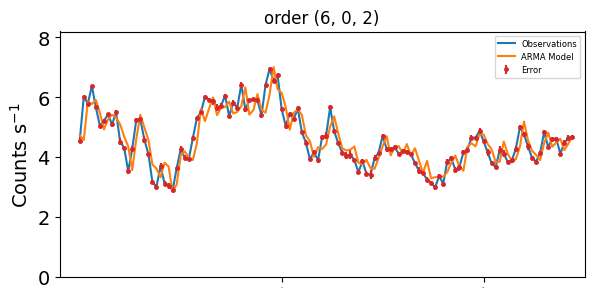

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.1912941058021154
R-squared value: 0.7741779173447767
Bayesian Information Criterion (BIC): 193.74570736431573
Corrected Akaike Information Criterion (AICc): 167.58814952487728


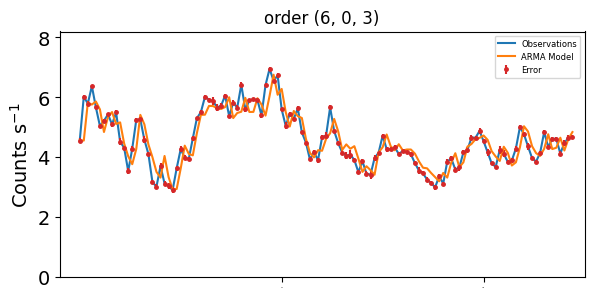

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.19082647946414957
R-squared value: 0.7747299487474228
Bayesian Information Criterion (BIC): 198.25684503180648
Corrected Akaike Information Criterion (AICc): 169.70119550108828


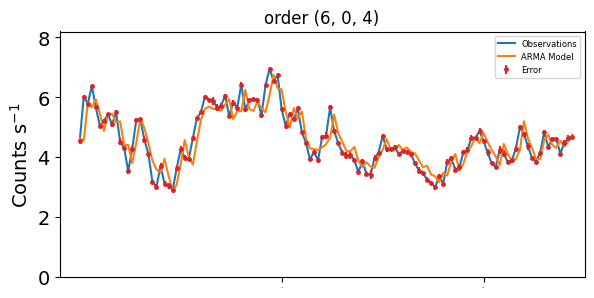

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.19186281895023397
R-squared value: 0.7735065532846922
Bayesian Information Criterion (BIC): 203.7352098574342
Corrected Akaike Information Criterion (AICc): 172.82536122932885


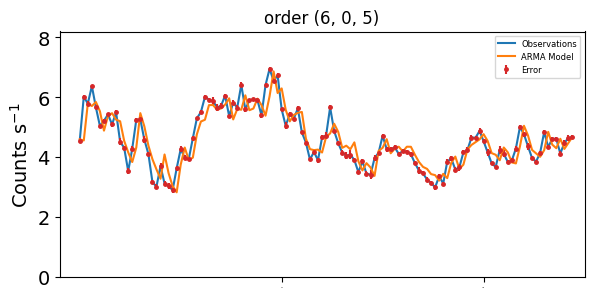

441220800.0
(123,)
Number of training data points: 123
(123, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-152-1f6dcb16a0cb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)


Mean Squared Error (MSE): 0.17707659725574457
R-squared value: 0.7909616409030507
Bayesian Information Criterion (BIC): 198.68301066732568
Corrected Akaike Information Criterion (AICc): 165.46406358876865


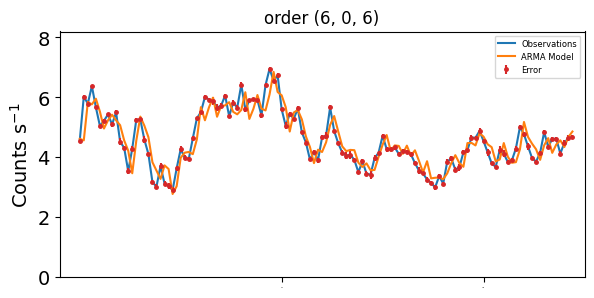

441220800.0


In [ ]:
# Plotting box 1 ARMA Model
for i in range(0, 7):
  for j in range(0, 7):
    fig, box1 = prepare_plot()
    juldate_zero, AICc, BIC, Order = process_and_plot_ARMA(data_files[0], box1, i, j)
    ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)
    plt.show()
    print(juldate_zero)


In [ ]:
ARMA_Result_Table_box1

Order         BIC        AICc
0   order (0, 0, 0)  330.681885  333.461012
1   order (0, 0, 1)  247.382192  252.906561
2   order (0, 0, 2)  198.254600  206.489473
3   order (0, 0, 3)  181.065917  191.975672
4   order (0, 0, 4)  174.190228  187.738330
5   order (0, 0, 5)  174.378225  190.527193
6   order (0, 0, 6)  173.671877  192.383255
7   order (1, 0, 0)  160.085449  165.609818
8   order (1, 0, 1)  162.186041  170.420913
9   order (1, 0, 2)  162.177027  173.086781
10  order (1, 0, 3)  161.842044  175.390145
11  order (1, 0, 4)  163.439425  179.588393
12  order (1, 0, 5)  165.387393  184.098770
13  order (1, 0, 6)  166.036442  187.270759
14  order (2, 0, 0)  162.185808  170.420680
15  order (2, 0, 1)  162.372765  173.282519
16  order (2, 0, 2)  163.479659  177.027760
17  order (2, 0, 3)  163.721007  179.869976
18  order (2, 0, 4)  165.627505  184.338882
19  order (2, 0, 5)  166.673048  187.907365
20  order (2, 0, 6)  165.313529  189.030267
21  order (3, 0, 0)  163.171135  174.080889
22  order (3, 0, 1)  163.699143  177.247245
23  order (3, 0, 2)  164.079164  180.228132
24  order (3, 0, 3)  164.351212  183.062589
25  order (3, 0, 4)  161.542457  182.776774
26  order (3, 0, 5)  163.807303  187.524042
27  order (3, 0, 6)  168.155109  194.312667
28  order (4, 0, 0)  161.647277  175.195378
29  order (4, 0, 1)  163.450350  179.599318
30  order (4, 0, 2)  163.346495  182.057873
31  order (4, 0, 3)  168.498287  189.732604
32  order (4, 0, 4)  167.028615  190.745353
33  order (4, 0, 5)  166.008084  192.165642
34  order (4, 0, 6)  164.610231  193.165880
35  order (5, 0, 0)  163.014688  179.163657
36  order (5, 0, 1)  165.194676  183.906054
37  order (5, 0, 2)  163.292256  184.526573
38  order (5, 0, 3)  166.889290  190.606029
39  order (5, 0, 4)  169.180226  195.337784
40  order (5, 0, 5)  168.050086  196.605735
41  order (5, 0, 6)  167.347918  198.257767
42  order (6, 0, 0)  164.923551  183.634928
43  order (6, 0, 1)  165.667274  186.901591
44  order (6, 0, 2)  159.455214  183.171953
45  order (6, 0, 3)  167.588150  193.745707
46  order (6, 0, 4)  169.701196  198.256845
47  order (6, 0, 5)  172.825361  203.735210
48  order (6, 0, 6)  165.464064  198.683011

import numpy as np
from google.colab import autoviz
df_1496610254981199857 = autoviz.get_registered_df('df_1496610254981199857')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_1496610254981199857, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6459566343515439577 = autoviz.get_registered_df('df_6459566343515439577')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_6459566343515439577, *['BIC'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8417805137545198359 = autoviz.get_registered_df('df_8417805137545198359')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8417805137545198359, *['AICc'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8431129790014648864 = autoviz.get_registered_df('df_8431129790014648864')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_8431129790014648864, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2192831164241392221 = autoviz.get_registered_df('df_2192831164241392221')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_2192831164241392221, *['BIC'], **{})
chart

import numpy as np
from google.colab import autoviz
df_466221710327878482 = autoviz.get_registered_df('df_466221710327878482')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_466221710327878482, *['AICc'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1401205115263524876 = autoviz.get_registered_df('df_1401205115263524876')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_1401205115263524876, *[[['index', 'BIC'], ['BIC', 'AICc']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_8374039959442794340 = autoviz.get_registered_df('df_8374039959442794340')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_8374039959442794340, *['index', 'BIC', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_6788693044495748408 = autoviz.get_registered_df('df_6788693044495748408')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_6788693044495748408, *['index', 'AICc', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_3200808661162311709 = autoviz.get_registered_df('df_3200808661162311709')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_3200808661162311709, *['index', 'count()', None], **{})
chart

In [ ]:
ARMA_Result_Table_box2 = pd.DataFrame(columns=['Order', 'BIC', 'AICc'])

In [ ]:
#Rectangular Box2
for i in range(0, 7):
  for j in range(0, 7):
    fig, box2 = prepare_plot()

    # Process and plot the combined data file on the second axes object
    juldate_zero, AICc, BIC, Order= process_and_plot_ARMA('fvar_soft_dt1000_combined.dat', box2, juldate_zero, i, j)
    plt.legend(loc='upper right', fontsize="40")
    ARMA_Result_Table_box1 = ARMA_Result_Table_box1.append({'Order': Order, 'BIC': BIC, 'AICc': AICc}, ignore_index=True)

    plt.show()  # display the plot

(481,)
Number of training data points: 481
(481, 1)


In [ ]:

# Rectangular Box3
for i in range(0, 7):
  for j in range(0, 7):
    rect_box3 = [left_h, bottom, width2, height]
    box3 = plt.axes(rect_box3)
    box3.set_ylim(0.,6.2)
    box3.set_xlim(-5.,125.)
    box3.xaxis.set_major_locator(FixedLocator([50,100]))
    box3.tick_params(which='major',axis='both', labelsize=0)

    process_and_plot_ARMA(data_files[-1], box3, i, j)
    plt.legend(loc='upper right', fontsize="40")
    plt.show()